# Prepare AFM tip solvation

This notebook demonstrates deposition of an SDS adsorption layer on a non-spherical AFM tip model.

## Initialization

### IPython magic

In [89]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [90]:
import ase.io # here used for reading pdb files
from ase.visualize import view
from ase.visualize.plot import plot_atoms # has nasty offset issues
from cycler import cycler # here used for cycling through colors in plots
import datetime
import fabric # for pythonic ssh connections
from fireworks import LaunchPad, Firework, Tracker, Workflow 
from fireworks import FileTransferTask, PyTask, ScriptTask

# FireWorks functionality 
from fireworks import Firework, LaunchPad, ScriptTask, Workflow
from fireworks.user_objects.firetasks.templatewriter_task import TemplateWriterTask
from fireworks.user_objects.firetasks.filepad_tasks import AddFilesTask, GetFilesTask, GetFilesByQueryTask
from imteksimfw.fireworks.user_objects.firetasks.cmd_tasks import CmdTask
from fireworks.utilities.filepad import FilePad # direct FilePad access, similar to the familiar LaunchPad

import glob
import gc # manually clean up memory with gc.collect()
import gromacs # GromacsWrapper, here used for evoking gmc commands, reading and writing .ndx files
# from io import StringIO, TextIOWrapper
import io
import itertools # for products of iterables
import json # generic serialization of lists and dicts
import jinja2 # here used for filling packmol input script template
import jinja2.meta # for gathering variables in a jinja2 template
import logging 
import matplotlib.pyplot as plt
import MDAnalysis as mda # here used for reading and analyzing gromacs trajectories
import MDAnalysis.analysis.rdf as mda_rdf
import MDAnalysis.analysis.rms as mda_rms
from mpl_toolkits.mplot3d import Axes3D # here used for 3d point cloud scatter plot
import miniball # finds minimum bounding sphere of a point set
import nglview
import numpy as np
import os, os.path
import pandas as pd
import panedr # reads GROMACS edr into pandas df, requires pandas and pbr
import parmed as pmd # has quite a few advantages over ASE when it comes to parsing pdb
from pprint import pprint
import pymongo # for sorting in queries
import scipy.constants as sc
import subprocess # used for evoking external packmol
import sys
import tempfile
import yaml

GromacsWrapper might need a file `~/.gromacswrapper.cfg` with content
```cfg
[Gromacs]
tools = gmx gmx_d 
# gmx_mpi_d gmx_mpi_d

# name of the logfile that is written to the current directory
logfilename = gromacs.log

# loglevels (see Python's logging module for details)
#   ERROR   only fatal errors
#   WARN    only warnings
#   INFO    interesting messages
#   DEBUG   everything

# console messages written to screen
loglevel_console = INFO

# file messages written to logfilename
loglevel_file = DEBUG
```
in order to know the GROMACS executables it is allowed to use. Otherwise,
calls to `gmx_mpi` or `gmx_mpi_d` without MPI wrapper might lead to MPI 
warnings in output that cause GromacsWrapper to fail.

### Logging

In [91]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

ParmEd needs to know the GROMACS topology folder, usually get this from 
envionment variable `GMXLIB`:

### Function definitions

In [92]:
def find_undeclared_variables(infile):
    """identify all variables evaluated in a jinja 2 template file"""
    env = jinja2.Environment()
    with open(infile) as template_file:
        parsed = env.parse(template_file.read())

    undefined = jinja2.meta.find_undeclared_variables(parsed)
    return undefined

In [93]:
def plot_side_views_with_spheres(atoms, cc, R, figsize=(12,4), fig=None, ax=None):
    """
    Plots xy, yz and zx projections of atoms and sphere(s) 
    
    Parameters
    ----------
    atoms: ase.atoms
        
    cc: (N,3) ndarray
        centers of spheres
    R:  (N,) ndarray
        radii of spheres
    figsize: 2-tuple, default (12,4)
    fig: matplotlib.figure, default None
    ax:  list of three matploblib.axes objects
    """
    
    logger = logging.getLogger(__name__)
    
    atom_radii = 0.5
    
    cc = np.array(cc,ndmin=2)
    logger.info("C({}) = {}".format(cc.shape,cc))
    R = np.array(R,ndmin=1)
    logger.info("R({}) = {}".format(R.shape,R))
    xmin = atoms.get_positions().min(axis=0)
    xmax = atoms.get_positions().max(axis=0)
    logger.info("xmin({}) = {}".format(xmin.shape,xmin))
    logger.info("xmax({}) = {}".format(xmax.shape,xmax))
    
    ### necessary due to ASE-internal atom position computations
    # see https://gitlab.com/ase/ase/blob/master/ase/io/utils.py#L69-82
    X1 = xmin - atom_radii
    X2 = xmax + atom_radii

    M = (X1 + X2) / 2
    S = 1.05 * (X2 - X1)

    scale = 1
    internal_offset = [ np.array(
        [scale * np.roll(M,i)[0] - scale * np.roll(S,i)[0] / 2, 
         scale * np.roll(M,i)[1] - scale * np.roll(S,i)[1] / 2]) for i in range(3) ]

    ### 
    atom_permut = [ atoms.copy() for i in range(3) ]

    for i, a in enumerate(atom_permut):
        a.set_positions( np.roll(a.get_positions(),i,axis=1) )

    rot      = ['0x,0y,0z']*3#,('90z,90x'),('90x,90y,0z')]
    label    = [ np.roll(np.array(['x','y','z'],dtype=str),i)[0:2] for i in range(3) ]
    
    # dim: sphere, view, coord
    center   = np.array([ 
        [ np.roll(C,i)[0:2] - internal_offset[i] for i in range(3) ] for C in cc ])

    logger.info("projected cc({}) = {}".format(center.shape,center))
    
    color_cycle = cycler(color=[
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
    circle   = [ [ plt.Circle( c , r, fill=False, **col) for c in C ] for C,r,col in zip(center,R,color_cycle) ]
    margin   = 1.1
    
    # dim: view, coord, minmax (i.e., 3,2,2)
    plot_bb = np.rollaxis( np.array(
        [ np.min(center - margin*(np.ones(center.T.shape)*R).T,axis=0),
          np.max(center + margin*(np.ones(center.T.shape)*R).T,axis=0) ] ).T, 1, 0)
    
    #plot_bb  = np.array( [ [
    #    [ [np.min(c[0]-margin*R[0]), np.max(c[0]+margin*R[0])], 
    #      [np.min(c[1]-margin*R[0]), np.max(c[1]+margin*R[0])] ] ) for c in C ] for C,r in zip(center,R) ] )
    logger.info("projected bb({}) = {}".format(plot_bb.shape,plot_bb))
    
    if ax is None:
        fig, ax = plt.subplots(1,3,figsize=figsize)
            
    (ax_xy, ax_xz, ax_yz)  = ax[:]
    logger.info("iterators len(atom_permut={}, len(ax)={}, len(rot)={}, len(circle)={}".format(
            len(atom_permut),len(ax),len(rot),len(circle)))
    
    #logger.info("len(circle)={}".format(len(circle))

    #for aa, a, r, C in zip(atom_permut,ax,rot,circle):
    for i, a in enumerate(ax):
        # rotation strings see https://gitlab.com/ase/ase/blob/master/ase/utils/__init__.py#L235-261
        plot_atoms(atom_permut[i],a,rotation=rot[i],radii=0.5,show_unit_cell=0,offset=(0,0))
        for j, c in enumerate(circle):
            logger.info("len(circle[{}])={}".format(j,len(c)))
            a.add_patch(c[i])

    for a,l,bb in zip(ax,label,plot_bb): 
        a.set_xlabel(l[0])
        a.set_ylabel(l[1])
        a.set_xlim(*bb[0,:])
        a.set_ylim(*bb[1,:])

    return fig, ax

In [94]:
def pack_sphere(C,
    R_inner_constraint, # shell inner radius
    R_outer_constraint, # shell outer radius
    sfN, # number  of surfactant molecules
    inner_atom_number, # inner atom
    outer_atom_number, # outer atom
    surfactant = 'SDS',
    counterion = 'NA',
    tolerance = 2):
    """Creates context for filling Jinja2 PACKMOL input template in order to
    generate preassembled surfactant spheres with couinterions at polar heads"""

    logger = logging.getLogger(__name__)
    logger.info(
        "sphere with {:d} surfactant molecules in total.".format(sfN ) )

    # sbX, sbY, sbZ = sb_measures

    # spheres parallelt to x-axis
    sphere = {}
    ionsphere = {}

    # surfactant spheres
    #   inner constraint radius: R + 1*tolerance
    #   outer constraint radius: R + 1*tolerance + l_surfactant
    # ions between cylindric planes at
    #   inner radius:            R + 1*tolerance + l_surfactant
    #   outer radius:            R + 2*tolerance + l_surfactant
    sphere["surfactant"] = surfactant

    
    sphere["inner_atom_number"] = inner_atom_number
    sphere["outer_atom_number"] = outer_atom_number

    sphere["N"] = sfN
        
    sphere["c"] = C

    sphere["r_inner"] = R_inner
    sphere["r_inner_constraint"] = R_inner_constraint
    sphere["r_outer_constraint"] = R_outer_constraint
    sphere["r_outer"] = R_outer
    
    logging.info(
        "sphere with {:d} molecules at {}, radius {}".format(
        sphere["N"], sphere["c"], sphere["r_outer"]))

    # ions at outer surface
    ionsphere["ion"] = counterion

    
    ionsphere["N"] = sphere["N"]
    ionsphere["c"] = sphere["c"]
    ionsphere["r_inner"] = sphere["r_outer"]
    ionsphere["r_outer"] = sphere["r_outer"] + tolerance


    # experience shows: movebadrandom advantegous for (hemi-) spheres
    context = {
        'spheres':     [sphere],
        'ionspheres':  [ionsphere],
        'movebadrandom': True,
    }
    return context

In [95]:
def memuse():
    """Quick overview on memory usage of objects in Jupyter notebook"""
    # https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    return sorted([(x, sys.getsizeof(globals().get(x))) for x in dir(sys.modules['__main__']) if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

### Global settings

In [96]:
os.environ['GMXLIB']

'/opt/apps/gromacs-top/jlh-2018.1/share/gromacs/top'

In [97]:
pmd.gromacs.GROMACS_TOPDIR = os.environ['GMXLIB']

In [98]:
prefix = '/mnt/dat/work/testuser/indenter/sandbox/20191110_packmol'

In [99]:
os.chdir(prefix)

### HPC-related settings

In [100]:
hpc_max_specs = {
    'forhlr2': {
        'fw_queue_category':   'forhlr2_queue',
        'fw_noqueue_category': 'forhlr2_noqueue',
        'queue':'develop',
        'physical_cores_per_node': 20,
        'logical_cores_per_node':  40,
        'nodes': 4,
        'walltime':  '00:60:00'
    },
    'juwels_devel': {
        'fw_queue_category':   'juwels_queue',
        'fw_noqueue_category': 'juwels_noqueue',
        'queue':'devel',
        'physical_cores_per_node': 48,
        'logical_cores_per_node':  96,
        'nodes': 8,
        'walltime':  '00:30:00'   
    },
    'juwels': {
        'fw_queue_category':   'juwels_queue',
        'fw_noqueue_category': 'juwels_noqueue',
        'queue':'batch',
        'physical_cores_per_node': 48,
        'logical_cores_per_node':  96,
        'nodes': 1024,
        'walltime':  '00:30:00'   
    }
}

In [101]:
std_exports = {
    'forhlr2': {
        'OMP_NUM_THREADS': 1,
        'KMP_AFFINITY':    "'verbose,compact,1,0'",
        'I_MPI_PIN_DOMAIN':'core'
    },
    'juwels': {
        'OMP_NUM_THREADS': 1,
        'KMP_AFFINITY':    "'verbose,compact,1,0'",
        'I_MPI_PIN_DOMAIN':'core'
    }
}

### FireWorks LaunchPad and FilePad

In [102]:
# the FireWorks LaunchPad
lp = LaunchPad.auto_load() #Define the server and database

In [103]:
# FilePad behaves analogous to LaunchPad
fp = FilePad.auto_load()

#### Sub-WF: PACKMOL

In [27]:
def sub_wf_pack(d, fws_root):    
    global project_id, \
        C, R_inner_constraint, R_outer_constraint, \
        tail_atom_number, head_atom_number, surfactant, counterion, tolerance, \
        fw_name_template, hpc_max_specs, machine
    # TODO: instead of global variables, use class
    
    fw_list = []
### Template
    
    files_in = {'input_file': 'input.template' }
    files_out = { 'input_file': 'input.inp' }
    
    # exports = std_exports[machine].copy()
        
    # Jinja2 context:
    packmol_script_context = {
        'header':        '{:s} packing SDS around AFM probe model'.format(project_id),
        'system_name':   '{:d}_SDS_on_50_Ang_AFM_tip_model'.format(d["nmolecules"]),
        'tolerance':     tolerance,
        'write_restart': True,

        'static_components': [
            {
                'name': 'indenter'
            }
        ]
    }

    # use pack_sphere function at the notebook's head to generate template context
    packmol_script_context.update(
        pack_sphere(
            C,R_inner_constraint,R_outer_constraint, d["nmolecules"], 
            tail_atom_number+1, head_atom_number+1, surfactant, counterion, tolerance))
    
    ft_template = TemplateWriterTask( {
        'context': packmol_script_context,
        'template_file': 'input.template',
        'template_dir': '.',
        'output_file': 'input.inp'} )
    
    
    fw_template = Firework([ft_template],
        name = ', '.join(('template', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in,
            '_files_out': files_out, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'fill_template',
                 **d
            }
        },
        parents = fws_root )
    
    fw_list.append(fw_template)

### PACKMOL

    files_in = {
        'input_file': 'input.inp',
        'indenter_file': 'indenter.pdb',
        'surfatcant_file': '1_SDS.pdb',
        'counterion_file': '1_NA.pdb' }
    files_out = {
        'data_file': '*_packmol.pdb'}
    
    ft_pack = CmdTask(
        cmd='packmol',
        opt=['< input.inp'],
        stderr_file  = 'std.err',
        stdout_file  = 'std.out',
        store_stdout = True,
        store_stderr = True,
        use_shell    = True,
        fizzle_bad_rc= True)
  
    fw_pack = Firework([ft_pack],
        name = ', '.join(('packmol', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_queue_category'],
            '_queueadapter': {
                'queue':           hpc_max_specs[machine]['queue'],
                'walltime' :       hpc_max_specs[machine]['walltime'],
                'ntasks':          1,
            },
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'packmol',
                 **d
            }
        },
        parents = [ *fws_root, fw_template] )
    
    fw_list.append(fw_pack)

    return fw_list, fw_pack

def sub_wf_pack_push(d, fws_root):
    global project_id, hpc_max_specs, machine

    fw_list = []   

    files_in = {'data_file': 'packed.pdb' }
    
    fts_push = [ AddFilesTask( {
        'compress': True ,
        'paths': "packed.pdb",
        'metadata': {
            'project': project_id,
            'datetime': str(datetime.datetime.now()),
            'type':    'initial_config',
             **d } 
        } ) ]
    
    fw_push = Firework(fts_push,
        name = ', '.join(('transfer', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'transfer',
                 **d
            }
        },
        parents = fws_root )
        
    fw_list.append(fw_push)
    
    return fw_list, fw_push

#### Sub-WF: GMX prep

In [28]:
def sub_wf_gmx_prep_pull(d, fws_root):
    global project_id, hpc_max_specs, machine
    
    fw_list = []   
    
    files_in = {}
    files_out = { 'data_file': 'in.pdb' }
            
    fts_pull = [ GetFilesByQueryTask(
            query = {
                'metadata->project':    source_project_id,
                'metadata->type':       'initial_config',
                'metadata->nmolecules': d["nmolecules"]
            },
            sort_key = 'metadata.datetime',
            sort_direction = pymongo.DESCENDING,
            limit = 1,
            new_file_names = ['in.pdb'] ) ]
    
    fw_pull = Firework(fts_pull,
        name = ', '.join(('fetch', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            '_files_out': files_out, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'fetch',
                 **d
            }
        },
        parents = fws_root )
    
    fw_list.append(fw_pull)
    
    return fw_list, fw_pull

def sub_wf_gmx_prep(d, fws_root):    
    global project_id, hpc_max_specs, machine
    # TODO: instead of global variables, use class
    
    fw_list = []   
    
### PDB chain

    files_in =  {'data_file': 'in.pdb' }
    files_out = {'data_file': 'out.pdb'}
    
    fts_pdb_chain = CmdTask(
        cmd='pdb_chain',
        opt=['< in.pdb > out.pdb'],
        store_stdout = False,
        store_stderr = False,
        use_shell    = True,
        fizzle_bad_rc= True)
  
    fw_pdb_chain = Firework(fts_pdb_chain,
        name = ', '.join(('pdb_chain', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'pdb_chain',
                 **d
            }
        },
        parents = fws_root )
    
    fw_list.append(fw_pdb_chain)
    
### PDB tidy
    files_in =  {'data_file': 'in.pdb' }
    files_out = {'data_file': 'out.pdb'}
    
    fts_pdb_tidy = CmdTask(
        cmd='pdb_tidy',
        opt=['< in.pdb > out.pdb'],
        store_stdout = False,
        store_stderr = False,
        use_shell    = True,
        fizzle_bad_rc= True)
  
    fw_pdb_tidy = Firework(fts_pdb_tidy,
        name = ', '.join(('pdb_tidy', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'pdb_tidy',
                 **d
            }
        },
        parents = [ fw_pdb_chain ] )
    
    fw_list.append(fw_pdb_tidy)
    
### GMX pdb2gro
    
    files_in =  {'data_file': 'in.pdb' }
    files_out = {
        'data_file': 'default.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp'}
    
    fts_gmx_pdb2gro = [ CmdTask(
        cmd='gmx',
        opt=['pdb2gmx',
             '-f', 'in.pdb',
             '-o', 'default.gro',
             '-p', 'default.top',
             '-i', 'default.posre.itp', 
             '-ff', 'charmm36',
             '-water' , 'tip3p'],
        stderr_file  = 'std.err',
        stdout_file  = 'std.out',
        store_stdout = True,
        store_stderr = True,
        use_shell    = True,
        fizzle_bad_rc= True) ]
  
    fw_gmx_pdb2gro = Firework(fts_gmx_pdb2gro,
        name = ', '.join(('gmx_pdb2gro', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'gmx_pdb2gro',
                 **d
            }
        },
        parents = [ fw_pdb_tidy ] )
    
    fw_list.append(fw_gmx_pdb2gro)
    
    
### GMX editconf
    files_in = {
        'data_file': 'in.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp'}
    files_out = {
        'data_file': 'default.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp'}
    
    fts_gmx_editconf = [ CmdTask(
        cmd='gmx',
        opt=['editconf',
             '-f', 'in.gro',
             '-o', 'default.gro',
             '-d', 2.0, # distance between content and box boundary in nm
             '-bt', 'cubic', # box type
          ],
        stderr_file  = 'std.err',
        stdout_file  = 'std.out',
        store_stdout = True,
        store_stderr = True,
        use_shell    = True,
        fizzle_bad_rc= True) ]
  
    fw_gmx_editconf = Firework(fts_gmx_editconf,
        name = ', '.join(('gmx_editconf', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'gmx_editconf',
                 **d
            }
        },
        parents = [ fw_gmx_pdb2gro ] )
    
    fw_list.append(fw_gmx_editconf)
    
    return fw_list, fw_gmx_editconf

def sub_wf_gmx_prep_push(d, fws_root):
    global project_id, hpc_max_specs, machine
    fw_list = []
    files_in = {
        'data_file': 'default.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp' }
    
    fts_push = [ 
        AddFilesTask( {
            'compress': True ,
            'paths': "default.gro",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'initial_config_gro',
                 **d } 
        } ),
        AddFilesTask( {
            'compress': True ,
            'paths': "default.top",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'initial_config_top',
                 **d } 
        } ),
        AddFilesTask( {
            'compress': True ,
            'paths': "default.posre.itp",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'initial_config_posre_itp',
                 **d } 
        } ) ]
        
               
    
    fw_push = Firework(fts_push,
        name = ', '.join(('push', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'push',
                 **d
            }
        },
        parents = fws_root )
        
    fw_list.append(fw_push)
    
    return fw_list, fw_push

#### Sub-WF: GMX EM

In [29]:
def sub_wf_gmx_em_pull(d, fws_root):
    global project_id, source_project_id, hpc_max_specs, machine
    
    fw_list = []   

    files_in = {}
    files_out = {
        'data_file': 'default.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp',
    }
            
    fts_fetch = [ 
        GetFilesByQueryTask(
            query = {
                'metadata->project':    source_project_id,
                'metadata->type':       'initial_config_gro',
                'metadata->nmolecules': d["nmolecules"]
            },
            sort_key = 'metadata.datetime',
            sort_direction = pymongo.DESCENDING,
            limit = 1,
            new_file_names = ['default.gro'] ),
        GetFilesByQueryTask(
            query = {
                'metadata->project':    source_project_id,
                'metadata->type':       'initial_config_top',
                'metadata->nmolecules': d["nmolecules"]
            },
            sort_key = 'metadata.datetime',
            sort_direction = pymongo.DESCENDING,
            limit = 1,
            new_file_names = ['default.top'] ), 
        GetFilesByQueryTask(
            query = {
                'metadata->project':    source_project_id,
                'metadata->type':       'initial_config_posre_itp',
                'metadata->nmolecules': d["nmolecules"]
            },
            sort_key = 'metadata.datetime',
            sort_direction = pymongo.DESCENDING,
            limit = 1,
            new_file_names = ['default.posre.itp'] ) ]
    
    fw_fetch = Firework(fts_fetch,
        name = ', '.join(('fetch', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            '_files_out': files_out, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'fetch',
                 **d
            }
        },
        parents = fws_root )
    
    fw_list.append(fw_fetch)
    
    return fw_list, fw_fetch

def sub_wf_gmx_em(d, fws_root):
    global project_id, hpc_max_specs, machine
    
    fw_list = []
### GMX grompp
    files_in = {
        'input_file':      'default.mdp',
        'data_file': 'default.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp'}
    files_out = {
        'input_file': 'default.tpr',
        'parameter_file': 'mdout.mdp' }
    
    fts_gmx_grompp = [ CmdTask(
        cmd='gmx',
        opt=[' grompp',
             '-f', 'default.mdp',
             '-c', 'default.gro',
             '-r', 'default.gro',
             '-o', 'default.tpr',
             '-p', 'default.top',
          ],
        stderr_file  = 'std.err',
        stdout_file  = 'std.out',
        store_stdout = True,
        store_stderr = True,
        use_shell    = True,
        fizzle_bad_rc= True) ]
  
    fw_gmx_grompp = Firework(fts_gmx_grompp,
        name = ', '.join(('gmx_grompp_em', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'gmx_grompp_em',
                 **d
            }
        },
        parents = fws_root )
    
    fw_list.append(fw_gmx_grompp)
    
### GMX mdrun

    files_in = {'input_file':   'em.tpr'}
    files_out = {
        'log_file':        'em.log',
        'energy_file':     'em.edr',
        'trajectory_file': 'em.trr',
        'data_file':    'em.gro' }
    
    fts_gmx_mdrun = [ CmdTask(
        cmd='gmx',
        opt=[' mdrun',
             '-deffnm', 'em', '-v' ],
        stderr_file  = 'std.err',
        stdout_file  = 'std.out',
        store_stdout = True,
        store_stderr = True,
        use_shell    = True,
        fizzle_bad_rc= True) ]
    
    fw_gmx_mdrun = Firework(fts_gmx_mdrun,
        name = ', '.join(('gmx_mdrun_em', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_queue_category'],
            '_queueadapter': {
                'queue':           hpc_max_specs[machine]['queue'],
                'walltime' :       hpc_max_specs[machine]['walltime'],
                'ntasks':          96,
            },
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'gmx_mdrun_em',
                 **d
            }
        },
        parents = [ fw_gmx_grompp ] )
    
    fw_list.append(fw_gmx_mdrun)
    
    return fw_list, fw_gmx_mdrun

def sub_wf_gmx_em_push(d, fws_root):
    global project_id, hpc_max_specs, machine

    fw_list = []
    files_in = {
        'log_file':        'em.log',
        'energy_file':     'em.edr',
        'trajectory_file': 'em.trr',
        'data_file':    'em.gro' }
    files_out = {}
    
    fts_push = [ 
        AddFilesTask( {
            'compress': True ,
            'paths': "em.log",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'em_log',
                 **d } 
        } ),
        AddFilesTask( {
            'compress': True ,
            'paths': "em.edr",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'em_edr',
                 **d } 
        } ),
        AddFilesTask( {
            'compress': True ,
            'paths': "em.trr",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'em_trr',
                 **d } 
        } ),
        AddFilesTask( {
            'compress': True ,
            'paths': "em.gro",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'em_gro',
                 **d } 
        } ) ]
    
    fw_push = Firework(fts_push,
        name = ', '.join(('push', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'push',
                 **d
            }
        },
        parents = fws_root )
        
    fw_list.append(fw_push)

    return fw_list, fw_push

#### Sub-WF: Pulling

In [ ]:
def sub_wf_pull_pull(d, fws_root):
    global project_id, source_project_id, hpc_max_specs, machine
    
    fw_list = []   

    files_in = {}
    files_out = {
        'data_file': 'default.gro',
    }
            
    fts_pull = [ 
        GetFilesByQueryTask(
            query = {
                'metadata->project':    source_project_id,
                'metadata->type':       'initial_config_gro',
                'metadata->nmolecules': d["nmolecules"]
            },
            sort_key = 'metadata.datetime',
            sort_direction = pymongo.DESCENDING,
            limit = 1,
            new_file_names = ['default.gro'] ) ]
    
    fw_pull = Firework(fts_pull,
        name = ', '.join(('fetch', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            '_files_out': files_out, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'fetch',
                 **d
            }
        },
        parents = fws_root )
    
    fw_list.append(fw_pull)
    
    return fw_list, fw_pull

def sub_wf_pull(d, fws_root):    
    global project_id, \
        surfactant, counterion, substrate, nsubstrate, \
        tail_atom_name, \
        fw_name_template, hpc_max_specs, machine
    
    fw_list = []

### System topolog template
    files_in = { 'template_file': 'sys.top.template' }
    files_out = { 'topology_file': 'sys.top' }
        
    # Jinja2 context:
    template_context = {
        'system_name':   '{nsurfactant:d}_{surfactant:s}_{ncounterion:d}_{counterion:s}_{nsubstrate:d}_{substrate:s}'.format(
            project_id=project_id, 
            nsurfactant=d["nmolecules"], surfactant=surfactant, 
            ncounterion=d["nmolecules"], counterion=counterion,
            nsubstrate=nsubstrate, substrate=substrate),
        'header':        '{project_id:s}: {nsurfactant:d} {surfactant:s} and {ncounterion:d} {counterion:s} around {nsubstrate:d}_{substrate:s} AFM probe model'.format(
            project_id=project_id, 
            nsurfactant=d["nmolecules"], surfactant=surfactant, 
            ncounterion=d["nmolecules"], counterion=counterion,
            nsubstrate=nsubstrate, substrate=substrate),
        'nsurfactant': d["nmolecules"],
        'surfactant':  surfactant,
        'ncounterion': d["nmolecules"],
        'counterion':  counterion,
        'nsubstrate':  nsubstrate,
        'substrate':   substrate,
    }
    
    fts_template = [ TemplateWriterTask( {
        'context': template_context,
        'template_file': 'sys.top.template',
        'template_dir': '.',
        'output_file': 'sys.top'} ) ]
    
    
    fw_template = Firework(fts_template,
        name = ', '.join(('template', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in,
            '_files_out': files_out, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'fill_template',
                 **d
            }
        },
        parents = fws_root )
    
    fw_list.append(fw_template)

### Index file

    files_in = {'data_file': 'default.gro'}
    files_out = {'index_file': 'default.ndx'}
    
    fts_gmx_make_ndx = [ 
        CmdTask(
            cmd='echo',
            opt=[' q','> std.in'],
            use_shell    = True,
            fizzle_bad_rc= True),
        CmdTask(
            cmd='gmx',
            opt=[' make_ndx',
                 '-f', 'default.gro',
                 '-o', 'default.ndx', '< std.in',
              ],
            stderr_file  = 'std.err',
            stdout_file  = 'std.out',
            store_stdout = True,
            store_stderr = True,
            use_shell    = True,
            fizzle_bad_rc= True) ]
    
    fw_gmx_make_ndx = Firework(fts_gmx_make_ndx,
        name = ', '.join(('gmx_make_ndx', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'gmx_make_ndx',
                 **d
            }
        },
        parents = fws_root )
    
    fw_list.append(fw_gmx_make_ndx)
    
### pulling groups

    files_in = {
        'data_file':     'default.gro',
        'topology_file': 'default.top',
        'index_file':    'in.ndx',
        #'substrate_itp':  '{}.itp'.format(substrate),
        #'surfactant_itp': '{}.itp'.format(substrate),
    }
    files_out = {
        'index_file':    'out.ndx',
        'topology_file': 'default.top', # pass unmodified
    }
    
    
    fts_extend_ndx = [ CmdTask(
        cmd='extend_ndx_by_per_atom_groups',
        opt=[
            '--verbose', '--log', 'default.log',
            '--topology-file', 'default.top',
            '--coordinates-file', 'default.gro',
            '--residue-name', surfactant,
            '--atom-name', tail_atom_name,
            'in.ndx', 'out.ndx'],
        stderr_file  = 'std.err',
        stdout_file  = 'std.out',
        store_stdout = True,
        store_stderr = True,
        fizzle_bad_rc= True) ]
  
    fw_extend_ndx = Firework(fts_extend_ndx,
        name = ', '.join(('extend_ndx_by_per_atom_groups', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'extend_ndx_by_per_atom_groups',
                 **d
            }
        },
        parents = [ *fws_root, fw_template, fw_gmx_make_ndx] )
    
    fw_list.append(fw_extend_ndx)

    return fw_list, fw_extend_ndx

def sub_wf_pull_push(d, fws_root):
    global project_id, hpc_max_specs, machine

    fw_list = []   

    files_in = {
        'topology_file': 'default.top',
        'index_file':    'default.ndx',
    }
    
    fts_push = [ 
        AddFilesTask( {
            'compress': True ,
            'paths': "default.top",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'top_pull',
                 **d } 
        } ),
        AddFilesTask( {
            'compress': True ,
            'paths': "default.ndx",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'ndx_pull',
                 **d } 
        } ),
    ]
    
    fw_push = Firework(fts_push,
        name = ', '.join(('push', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'push',
                 **d
            }
        },
        parents = fws_root )
        
    fw_list.append(fw_push)
    
    return fw_list, fw_push

## Conversion from LAMMPS data format to PDB

The vollowing bash / tcl snippet converts a LAMMPS data file to PDB, assigning the desired names as mapped in a yaml file
```bash
#!/bin/bash
# echo "package require jlhvmd; jlh lmp2pdb indenter.lammps indenter.pdb" | vmd -eofexit
vmd -eofexit << 'EOF'
package require jlhvmd
topo readlammpsdata indenter.lammps
jlh type2name SDS_type2name.yaml
jlh name2res  SDS_name2res.yaml
set sel [atomselect top all]
$sel writepdb indenter.pdb
EOF

pdb_chain.py indenter.pdb > indenter_wo_chainid.pdb
pdb_reres_by_atom_9999.py indenter_wo_chainid.pdb > indenter_reres.pdb
```

Requires

* VMD (tested with 1.9.3) with topotools
* jlhvmd VMD plugin: https://github.com/jotelha/jlhvmd
* pdb-tools: https://github.com/haddocking/pdb-tools/

## Inspect AFM tip model

### Read pdb

In [31]:
infile = os.path.join(prefix,'indenter_reres.pdb')

In [32]:
atoms = ase.io.read(infile,format='proteindatabank')

In [33]:
atoms

Atoms(symbols='Au3873', pbc=True, cell=[47.832, 49.629, 47.369], atomtypes=..., bfactor=..., occupancy=..., residuenames=..., residuenumbers=...)

### Display with ASE view

In [34]:
v = view(atoms,viewer='ngl')
v.view._remote_call("setSize", target="Widget", args=["400px", "400px"])
v.view.center()
v.view.background='#ffc'
v

### Get the bounding sphere around point set

In [35]:
S = atoms.get_positions()

In [36]:
C, R_sq = miniball.get_bounding_ball(S)

In [37]:
C # sphere center

array([-0.02151743, -0.17756268,  0.46946046])

In [38]:
R = np.sqrt(R_sq)

In [39]:
R # sphere radius

26.390609083217864

In [40]:
xmin = atoms.get_positions().min(axis=0)
xmax = atoms.get_positions().max(axis=0)

In [41]:
xmin

array([-24.053, -26.065, -22.045])

In [42]:
del S

### Plot 2d projections of point set and bounding sphere

INFO:__main__:C((1, 3)) = [[-0.02151743 -0.17756268  0.46946046]]
INFO:__main__:R((1,)) = [26.39060908]
INFO:__main__:xmin((3,)) = [-24.053 -26.065 -22.045]
INFO:__main__:xmax((3,)) = [24.555 25.426 21.998]
INFO:__main__:projected cc((1, 3, 2)) = [[[25.77168257 27.69971232]
  [24.14053546 25.77168257]
  [27.69971232 24.14053546]]]
INFO:__main__:projected bb((3, 2, 2)) = [[[-3.25798742 54.80135256]
  [-1.32995767 56.72938231]]

 [[-4.88913453 53.17020545]
  [-3.25798742 54.80135256]]

 [[-1.32995767 56.72938231]
  [-4.88913453 53.17020545]]]
INFO:__main__:iterators len(atom_permut=3, len(ax)=3, len(rot)=3, len(circle)=1
INFO:__main__:len(circle[0])=3
INFO:__main__:len(circle[0])=3
INFO:__main__:len(circle[0])=3


(<Figure size 864x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a9947e198>,
       dtype=object))

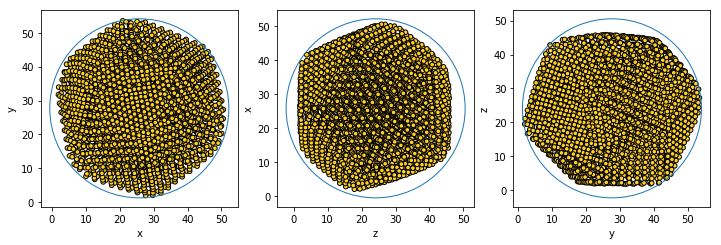

In [43]:
# plot side views with sphere projections
plot_side_views_with_spheres(atoms,C,R)

### Plot 3d point set and bounding sphere

In [44]:
# bounding sphere surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
us = np.array([
    np.outer(np.cos(u), np.sin(v)),
    np.outer(np.sin(u), np.sin(v)), 
    np.outer(np.ones(np.size(u)), np.cos(v))])
bs = C + R*us.T

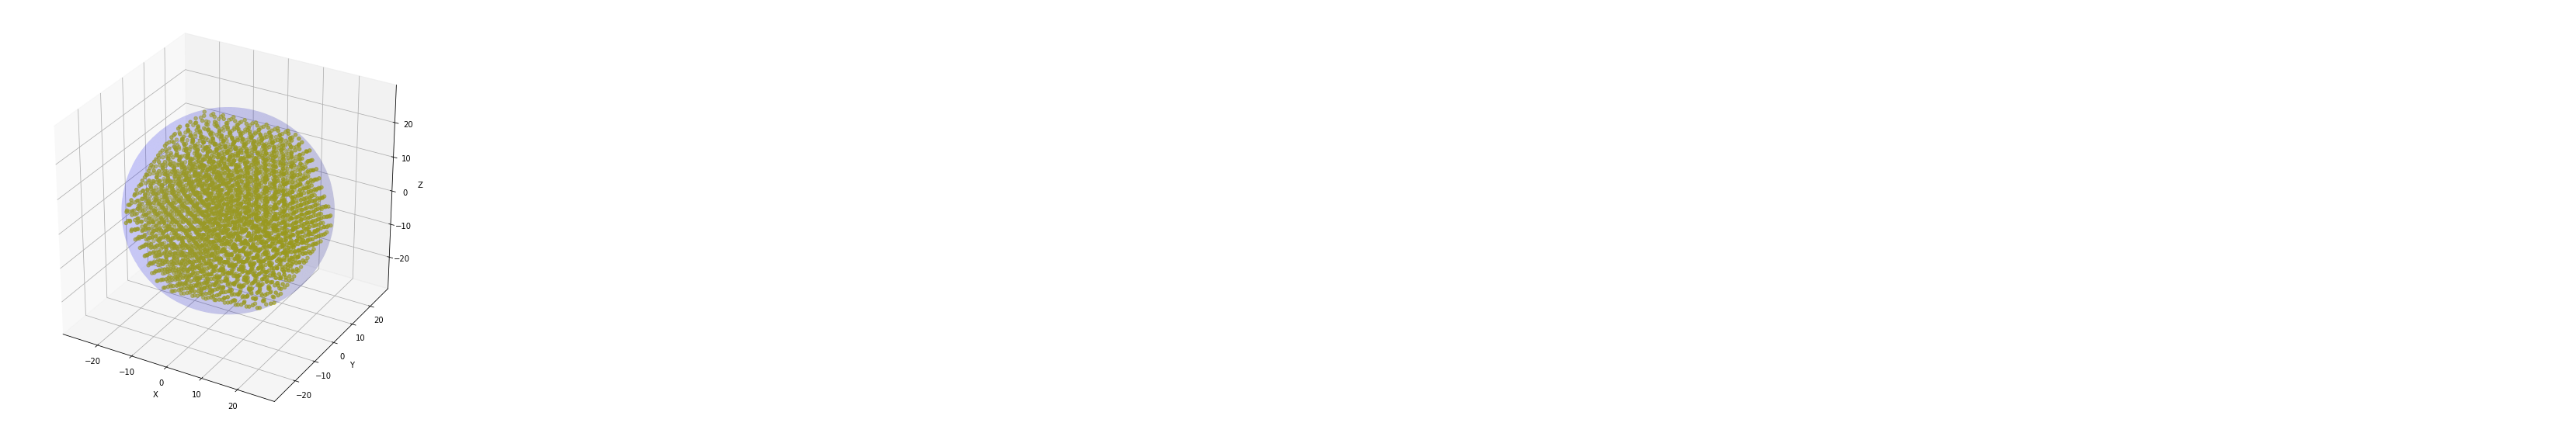

In [45]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = atoms.get_positions()
ax.scatter(x[:,0], x[:,1],x[:,2], c='y', marker='o')
ax.plot_surface(*bs.T, color='b',alpha=0.1) # bounding sphere
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

## Measure surfactant molecule

In [46]:
tol = 2 # Ang

### Read single surfactant molecule PDB with ParmEd

Utilize parmed to read pbd files ASE has difficulties to decipher.

In [168]:
infile = os.path.join(prefix,'1_SDS.pdb')

In [169]:
surfactant_pmd = pmd.load_file(infile)

In [170]:
surfactant_pmd.atoms[-1].atomic_number

0

### Convert ParmEd structure to ASE atoms

In [171]:
surfactant_ase = ase.Atoms(
    numbers=[1 if a.atomic_number == 0 else a.atomic_number for a in surfactant_pmd.atoms],
    positions=surfactant_pmd.get_coordinates(0))

### Get bounding sphere of single surfactant molecule

In [172]:
C_surfactant, R_sq_surfactant = miniball.get_bounding_ball(surfactant_ase.get_positions())

In [173]:
C_surfactant

array([ 1.885,  0.545, 15.47 ])

In [174]:
R_surfactant = np.sqrt(R_sq_surfactant)

In [175]:
R_surfactant

7.758430898061799

In [176]:
C_surfactant

array([ 1.885,  0.545, 15.47 ])

In [177]:
surfactant_ase[:5][1]

Atom('O', [3.47, 0.7, 20.88], index=1)

### Estimate constraint sphere radii

In [178]:
R_OSL = np.linalg.norm(C_surfactant - surfactant_ase[1].position)

In [179]:
R_OSL

5.639534555262515

In [180]:
d_head = R_surfactant - R_OSL # roughly: diameter of head group

In [181]:
R_inner = R + tol # place surfactant molecules outside of this sphere

In [182]:
R_inner_constraint = R + tol + d_head # place surfactant tail hydrocarbon within this sphere

In [183]:
R_outer_constraint = R + 2*R_surfactant + tol # place head group sulfur outside this sphere

In [184]:
R_outer = R + 2*R_surfactant + 2*tol # place suractant molecules within this sphere

In [185]:
rr = [R,R_inner,R_inner_constraint,R_outer_constraint,R_outer]

In [186]:
cc = [C]*5

### Show 2d projections of geometrical constraints around AFM tip model

INFO:__main__:C((5, 3)) = [[-0.02151743 -0.17756268  0.46946046]
 [-0.02151743 -0.17756268  0.46946046]
 [-0.02151743 -0.17756268  0.46946046]
 [-0.02151743 -0.17756268  0.46946046]
 [-0.02151743 -0.17756268  0.46946046]]
INFO:__main__:R((5,)) = [26.39060908 28.39060908 30.50950543 43.90747088 45.90747088]
INFO:__main__:xmin((3,)) = [-24.053 -26.065 -22.045]
INFO:__main__:xmax((3,)) = [24.555 25.426 21.998]
INFO:__main__:projected cc((5, 3, 2)) = [[[25.77168257 27.69971232]
  [24.14053546 25.77168257]
  [27.69971232 24.14053546]]

 [[25.77168257 27.69971232]
  [24.14053546 25.77168257]
  [27.69971232 24.14053546]]

 [[25.77168257 27.69971232]
  [24.14053546 25.77168257]
  [27.69971232 24.14053546]]

 [[25.77168257 27.69971232]
  [24.14053546 25.77168257]
  [27.69971232 24.14053546]]

 [[25.77168257 27.69971232]
  [24.14053546 25.77168257]
  [27.69971232 24.14053546]]]
INFO:__main__:projected bb((3, 2, 2)) = [[[-24.7265354   76.26990054]
  [-22.79850565  78.19793029]]

 [[-26.35768251  

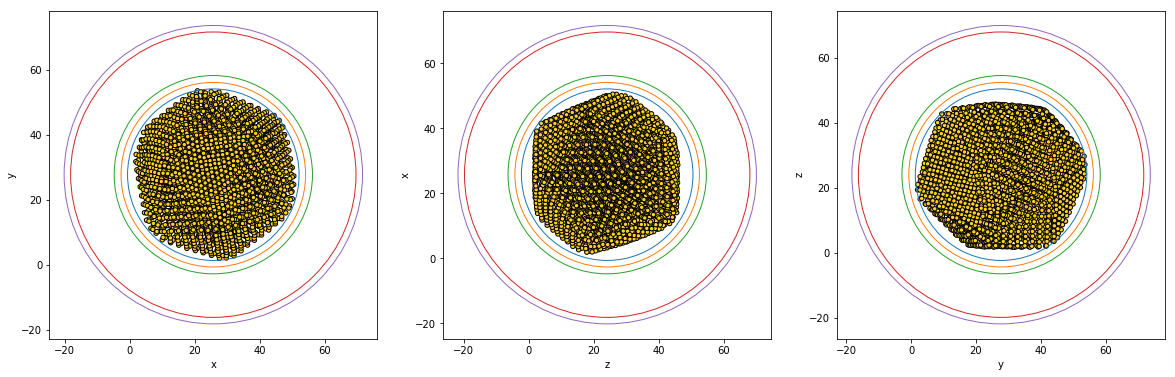

In [187]:
plot_side_views_with_spheres(atoms,cc,rr,figsize=(20,8))
plt.show()

## Packing the surfactant film

In [188]:
infile_prefix = os.path.join(prefix,'packmol_infiles')

### Identify placeholders in jinja2 template

The template looks like this:

In [189]:
with open(os.path.join(infile_prefix,'surfactants_on_sphere.inp'),'r') as f:
    print(f.read())

# {{ system_name }}
# {{ header }}

# Change the maximum number of optimization loops, default 20
nloop {{ nloop|default(20,true)|int }}
# Change the maximum number of Gencan iterations per loop. default 50
maxit {{ maxit|default(50,true)|int }}

tolerance {{ "%.3f"|format(tolerance) }}

{% if movebadrandom %}
# One of the convergence heuristics of Packmol consists in moving molecules
# that are badly placed. If this option is set, the molecules will be placed
# in new random position in the box. If not (default), the molecules are
# moved to positions nearby molecules that are well packed. Using this
# option can help when the restraints are complex, but will probably be bad
# if there are large structures, because the new random position might overlap
# with those.
movebadrandom
{% endif %}

# Coordinate file types will be in pdb format (keyword not required for
# pdb file format, but required for tinker, xyz or moldy).

filetype pdb

output {{ system_name }}_packmol.pdb

{% if write

In [190]:
# get all placholders in template
template_file = os.path.join(infile_prefix,'surfactants_on_sphere.inp')

In [191]:
v = find_undeclared_variables(template_file)

In [192]:
v # we want to fill in these placeholder variables

{'header',
 'ionspheres',
 'maxit',
 'movebadrandom',
 'nloop',
 'spheres',
 'static_components',
 'system_name',
 'tolerance',
 'write_restart'}

### System and constraint parameters

In [193]:
surfactant = 'SDS'
counterion = 'NA'
tolerance = 2 # Ang
sfN = 200

In [194]:
l_surfactant = 2*R_surfactant

In [195]:
# head atom to be geometrically constrained
surfactant_head_bool_ndx = np.array([ a.name == 'S' for a in surfactant_pmd.atoms ],dtype=bool)

In [196]:
# tail atom to be geometrically constrained
surfactant_tail_bool_ndx = np.array([ a.name == 'C12' for a in surfactant_pmd.atoms ],dtype=bool)

In [197]:
head_atom_number = surfactant_head_ndx = np.argwhere(surfactant_head_bool_ndx)[0,0]

In [198]:
tail_atom_number = surfactant_tail_ndx = np.argwhere(surfactant_tail_bool_ndx)[0,0]

In [199]:
# settings can be overridden
packmol_script_context = {
    'header':        '20191113 TEST PACKING',
    'system_name':   '200_SDS_on_50_Ang_AFM_tip_model',
    'tolerance':     tolerance,
    'write_restart': True,
    
    'static_components': [
        {
            'name': 'indenter_reres'
        }
    ]
}

# use pack_sphere function at the notebook's head to generate template context
packmol_script_context.update(
    pack_sphere(
        C,R_inner_constraint,R_outer_constraint, sfN, 
        tail_atom_number+1, head_atom_number+1, surfactant, counterion, tolerance))

INFO:__main__:sphere with 200 surfactant molecules in total.
INFO:root:sphere with 200 molecules at [-0.02151743 -0.17756268  0.46946046], radius 45.90747087934146


In [200]:
packmol_script_context # context generated from system and constraint settings

{'header': '20191113 TEST PACKING',
 'system_name': '200_SDS_on_50_Ang_AFM_tip_model',
 'tolerance': 2,
 'write_restart': True,
 'static_components': [{'name': 'indenter_reres'}],
 'spheres': [{'surfactant': 'SDS',
   'inner_atom_number': 39,
   'outer_atom_number': 1,
   'N': 200,
   'c': array([-0.02151743, -0.17756268,  0.46946046]),
   'r_inner': 28.39060908321786,
   'r_inner_constraint': 30.509505426017142,
   'r_outer_constraint': 43.90747087934146,
   'r_outer': 45.90747087934146}],
 'ionspheres': [{'ion': 'NA',
   'N': 200,
   'c': array([-0.02151743, -0.17756268,  0.46946046]),
   'r_inner': 45.90747087934146,
   'r_outer': 47.90747087934146}],
 'movebadrandom': True}

### Fill a packmol input script template with jinja2

In [201]:
env = jinja2.Environment()

In [202]:
template = jinja2.Template(open(template_file).read())

In [203]:
rendered = template.render(**packmol_script_context)

In [204]:
rendered_file = os.path.join(prefix,'rendered.inp')

In [205]:
with open(rendered_file,'w') as f:
    f.write(rendered)

That's the rendered packmol input file:

In [206]:
print(rendered)

# 200_SDS_on_50_Ang_AFM_tip_model
# 20191113 TEST PACKING

# Change the maximum number of optimization loops, default 20
nloop 20
# Change the maximum number of Gencan iterations per loop. default 50
maxit 50

tolerance 2.000


# One of the convergence heuristics of Packmol consists in moving molecules
# that are badly placed. If this option is set, the molecules will be placed
# in new random position in the box. If not (default), the molecules are
# moved to positions nearby molecules that are well packed. Using this
# option can help when the restraints are complex, but will probably be bad
# if there are large structures, because the new random position might overlap
# with those.
movebadrandom


# Coordinate file types will be in pdb format (keyword not required for
# pdb file format, but required for tinker, xyz or moldy).

filetype pdb

output 200_SDS_on_50_Ang_AFM_tip_model_packmol.pdb


restart_to 200_SDS_on_50_Ang_AFM_tip_model_restart.pack




 
structure indenter_reres.pdb


### Fail running packmol once

In [207]:
packmol = subprocess.Popen(['packmol'],
        stdin=subprocess.PIPE,stdout=subprocess.PIPE, stderr=subprocess.PIPE,
        cwd=prefix, encoding='utf-8')

In [208]:
outs, errs = packmol.communicate(input=rendered)

In [209]:
print(errs) # error with input from PIPE

At line 85 of file setsizes.f90 (unit = 5, file = 'stdin')
Fortran runtime error: Illegal seek

Error termination. Backtrace:
#0  0x7f76155732ed in ???
#1  0x7f7615573ed5 in ???
#2  0x7f761557469d in ???
#3  0x55a94a674b78 in ???
#4  0x55a94a68e797 in ???
#5  0x55a94a65e29e in ???
#6  0x7f7614deab96 in ???
#7  0x55a94a65e2f9 in ???
#8  0xffffffffffffffff in ???



### Read packmol input from file to avoid obscure Fortran error

In [210]:
packmol = subprocess.Popen(['packmol'],
        stdin=open(rendered_file,'r'),stdout=subprocess.PIPE, stderr=subprocess.PIPE,
        cwd=prefix, encoding='utf-8')

In [211]:
outs, errs = packmol.communicate(input=rendered)

In [212]:
print(outs)


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 18.169 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: www.ime.unicamp.br/~martinez/packmol 

  Reading input file... (Control-C aborts)
  User defined GENCAN number of iterations:           50
  Will move randomly bad molecues (movebadrandom) 
  Seed for random number generator:      1234567
  Output file: 200_SDS_on_50_Ang_AFM_tip_model_packmol.pdb
  Reading coordinate file: indenter_reres.pdb
  Reading coordinate file: 1_SDS.pdb
  Reading coordinate file: 1_NA.pdb
  Number of independent structures:            3
  The structures are: 
  Structure            1 :indenter_reres.pdb(        3873  atoms)
  St

In [213]:
with open('packmol.log','w') as f:
    f.write(outs)

### Inspect packed systems

In [214]:
packmol_pdb = '200_SDS_on_50_Ang_AFM_tip_model_packmol.pdb'

In [215]:
infile = os.path.join(prefix, packmol_pdb)

In [216]:
surfactant_shell_pmd = pmd.load_file(infile)

In [217]:
# with ParmEd and nglview we get automatic bond guessing
pmd_view = nglview.show_parmed(surfactant_shell_pmd)
pmd_view.clear_representations()
pmd_view.background = 'white'
pmd_view.add_representation('ball+stick')
pmd_view

NGLWidget()

In [218]:
surfactant_shell_ase = ase.Atoms(
    numbers=[1 if a.atomic_number == 0 else a.atomic_number for a in surfactant_shell_pmd.atoms],
    positions=surfactant_shell_pmd.get_coordinates(0))

In [219]:
# with ASE, we get no bonds at all
ase_view = nglview.show_ase(surfactant_shell_ase)
ase_view.clear_representations()
ase_view.background = 'white'
ase_view.add_representation('ball+stick')
ase_view

NGLWidget()

Get bounding sphere again and display AFM tip bounding spphere as well as surfactant layer bounding sphere

In [220]:
C_shell, R_sq_shell = miniball.get_bounding_ball(surfactant_shell_ase.get_positions())

In [221]:
C_shell

array([-0.02227057, -0.1778993 ,  0.46945477])

In [222]:
R_shell = np.sqrt(R_sq_shell)

In [223]:
R_shell

47.90718822322802

INFO:__main__:C((2, 3)) = [[-0.02151743 -0.17756268  0.46946046]
 [-0.02227057 -0.1778993   0.46945477]]
INFO:__main__:R((2,)) = [26.39060908 47.90718822]
INFO:__main__:xmin((3,)) = [-47.065 -47.43  -45.014]
INFO:__main__:xmax((3,)) = [45.898 46.291 44.553]
INFO:__main__:projected cc((2, 3, 2)) = [[[49.89255757 50.12046232]
  [48.24763546 49.89255757]
  [50.12046232 48.24763546]]

 [[49.89180443 50.1201257 ]
  [48.24762977 49.89180443]
  [50.1201257  48.24762977]]]
INFO:__main__:projected bb((3, 2, 2)) = [[[ -2.80610262 102.58971148]
  [ -2.57778135 102.81803274]]

 [[ -4.45027727 100.94553682]
  [ -2.80610262 102.58971148]]

 [[ -2.57778135 102.81803274]
  [ -4.45027727 100.94553682]]]
INFO:__main__:iterators len(atom_permut=3, len(ax)=3, len(rot)=3, len(circle)=2
INFO:__main__:len(circle[0])=3
INFO:__main__:len(circle[1])=3
INFO:__main__:len(circle[0])=3
INFO:__main__:len(circle[1])=3
INFO:__main__:len(circle[0])=3
INFO:__main__:len(circle[1])=3


(<Figure size 864x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb65d31fd0>,
       dtype=object))

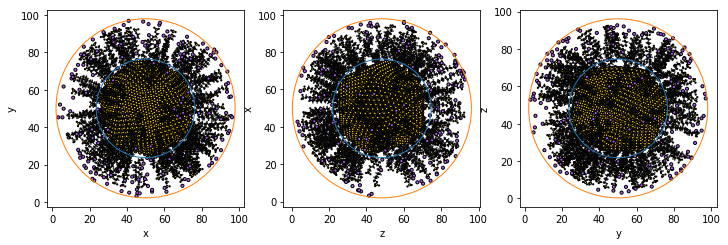

In [224]:
plot_side_views_with_spheres(surfactant_shell_ase,[C,C_shell],[R,R_shell])

In [342]:
surfactant_shell_pmd

<Structure 12473 atoms; 4273 residues; 9200 bonds; NOT parametrized>

### Batch processing: Parametric jobs


#### Generate parameter sets

In [54]:
R # Angstrom

26.390609083217864

In [55]:
A_Ang = 4*np.pi*R**2 # area in Ansgtrom

In [56]:
A_nm = A_Ang / 10**2

In [57]:
A_nm

87.52027857294837

In [58]:
n_per_nm_sq = np.array([0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0]) # molecules per square nm

In [59]:
N = np.round(A_nm*n_per_nm_sq).astype(int)

In [60]:
N # molecule numbers corresponding to surface concentrations

array([  0,  44,  88, 131, 175, 219, 263, 306, 350, 394, 438, 481, 525])

#### Provide PACKMOL template 

In [54]:
project_id = 'juwels-packmol-2020-03-09'

In [17]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [18]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

19

In [160]:
infiles = sorted(glob.glob(os.path.join(infile_prefix,'*.inp')))

files = { os.path.basename(f): f for f in infiles }

# metadata common to all these files 
metadata = {
    'project': project_id,
    'type': 'template'
}

fp_files = []

# insert these input files into data base
for name, file_path in files.items():
    identifier = '/'.join((project_id,name)) # identifier is like a path on a file system
    metadata["name"] = name
    fp_files.append( fp.add_file(file_path,identifier=identifier,metadata = metadata) )

In [224]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.type': 'template'
}

# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [171]:
print(identifier)

juwels-packmol-2020-03-09/surfactants_on_sphere.inp


In [172]:
# on a lower level, each object has a unique "GridFS id":
pprint(fp_files) # underlying GridFS id and readable identifiers

[('5e66570411940f3ff823ef88',
  'juwels-packmol-2020-03-09/surfactants_on_sphere.inp')]


#### Provide data files

In [272]:
data_prefix = os.path.join(prefix,'packmol_datafiles')

In [273]:
datafiles = sorted(glob.glob(os.path.join(data_prefix,'*')))

files = { os.path.basename(f): f for f in datafiles }

# metadata common to all these files 
metadata = {
    'project': project_id,
    'type': 'data'
}

fp_files = []

# insert these input files into data base
for name, file_path in files.items():
    identifier = '/'.join((project_id,name)) # identifier is like a path on a file system
    metadata["name"] = name
    fp_files.append( fp.add_file(file_path,identifier=identifier,metadata = metadata) )


2020-03-09 18:09:50,170 WARNING identifier: juwels-packmol-2020-03-09/1_SDS.pdb exists. Skipping insertion


2020-03-09 18:09:50,186 WARNING identifier: juwels-packmol-2020-03-09/indenter_reres.pdb exists. Skipping insertion


In [274]:
fp_files

[('5e66785e11940f3ff823ef9b', 'juwels-packmol-2020-03-09/1_NA.pdb'),
 ('5e6669c111940f3ff823ef8b', 'juwels-packmol-2020-03-09/1_SDS.pdb'),
 ('5e6669c111940f3ff823ef8e', 'juwels-packmol-2020-03-09/indenter_reres.pdb')]

#### Span parameter sets

In [485]:
machine = 'juwels_devel'

In [480]:
parametric_dimension_labels = ['nmolecules']

In [481]:
parametric_dimensions = [ {
    'nmolecules': N } ]

In [458]:
# for testing
parametric_dimensions = [ {
    'nmolecules': [N[0]] } ]

In [482]:
parameter_sets = list( 
    itertools.chain(*[ 
            itertools.product(*list(
                    p.values())) for p in parametric_dimensions ]) )

parameter_dict_sets = [ dict(zip(parametric_dimension_labels,s)) for s in parameter_sets ]

In [486]:
wf_name = 'PACKMOL {machine:}, {id:}'.format(machine=machine,id=project_id)

fw_name_template = 'nmolecules: {nmolecules:d}'

fw_list = []

fts = [ 
        GetFilesByQueryTask(
            query = {
                'metadata->project': project_id,
                'metadata->name':    'surfactants_on_sphere.inp'
            },
            limit = 1,
            new_file_names = ['input.template'] ),
        GetFilesByQueryTask(
            query = {
                'metadata->project': project_id,
                'metadata->name':    'indenter_reres.pdb'
            },
            limit = 1,
            new_file_names = ['indenter.pdb'] ),
        GetFilesByQueryTask(
            query = {
                'metadata->project': project_id,
                'metadata->name':    '1_SDS.pdb'
            },
            limit = 1,
            new_file_names = ['1_SDS.pdb'] ),
        GetFilesByQueryTask(
            query = {
                'metadata->project': project_id,
                'metadata->name':    '1_NA.pdb'
            },
            limit = 1,
            new_file_names = ['1_NA.pdb'] )
        ]

files_out = {
    'input_file': 'input.template',
    'indenter_file': 'indenter.pdb',
    'surfatcant_file': '1_SDS.pdb',
    'counterion_file': '1_NA.pdb'}

fw_root = Firework(fts,
    name = wf_name,
    spec = {
        '_category': hpc_max_specs[machine]['fw_noqueue_category'],
        '_files_out': files_out, 
        'metadata': {
          'project': project_id,
          'datetime': str(datetime.datetime.now()),
          'step':    'input_file_query'
        }
    }
)

fw_list.append(fw_root)

## Parametric sweep

for d in parameter_dict_sets:        
    
### Template
    
    files_in = {'input_file': 'input.template' }
    files_out = { 'input_file': 'input.inp' }
    
    # exports = std_exports[machine].copy()
        
    # Jinja2 context:
    packmol_script_context = {
        'header':        '{:s} packing SDS around AFM probe model'.format(project_id),
        'system_name':   '{:d}_SDS_on_50_Ang_AFM_tip_model'.format(n),
        'tolerance':     tolerance,
        'write_restart': True,

        'static_components': [
            {
                'name': 'indenter'
            }
        ]
    }

    # use pack_sphere function at the notebook's head to generate template context
    packmol_script_context.update(
        pack_sphere(
            C,R_inner_constraint,R_outer_constraint, d["nmolecules"], 
            tail_atom_number+1, head_atom_number+1, surfactant, counterion, tolerance))
    
    ft_template = TemplateWriterTask( {
        'context': packmol_script_context,
        'template_file': 'input.template',
        'template_dir': '.',
        'output_file': 'input.inp'} )
    
    
    fw_template = Firework([ft_template],
        name = ', '.join(('template', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in,
            '_files_out': files_out, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'fill_template',
                 **d
            }
        },
        parents = [ fw_root ] )
    
    fw_list.append(fw_template)

### PACKMOL

    files_in = {
        'input_file': 'input.inp',
        'indenter_file': 'indenter.pdb',
        'surfatcant_file': '1_SDS.pdb',
        'counterion_file': '1_NA.pdb' }
    files_out = {
        'data_file': '*_packmol.pdb'}
    
    ft_pack = CmdTask(
        cmd='packmol',
        opt=['< input.inp'],
        stderr_file  = 'std.err',
        stdout_file  = 'std.out',
        store_stdout = True,
        store_stderr = True,
        use_shell    = True,
        fizzle_bad_rc= True)
  
    fw_pack = Firework([ft_pack],
        name = ', '.join(('packmol', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_queue_category'],
            '_queueadapter': {
                'queue':           hpc_max_specs[machine]['queue'],
                'walltime' :       hpc_max_specs[machine]['walltime'],
                'ntasks':          1,
            },
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'packmol',
                 **d
            }
        },
        parents = [ fw_root, fw_template] )
    
    fw_list.append(fw_pack)

### Store

    files_in = {'data_file': 'packed.pdb' }
    
    ft_transfer = AddFilesTask( {
        'compress': True ,
        'paths': "packed.pdb",
        'metadata': {
            'project': project_id,
            'datetime': str(datetime.datetime.now()),
            'type':    'initial_config',
             **d } 
        } )
    
    fw_transfer = Firework([ft_transfer],
        name = ', '.join(('transfer', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'transfer',
                 **d
            }
        },
        parents = [ fw_pack ] )
        
    fw_list.append(fw_transfer)

wf = Workflow(fw_list,
    name = wf_name,
    metadata = {
        'project': project_id,
        'datetime': str(datetime.datetime.now()),
        'type':    'packing'
    })

In [488]:
wf.to_file('packing.json')

In [489]:
lp.add_wf(wf)

2020-03-09 23:30:50,388 INFO Added a workflow. id_map: {-90: 24016, -89: 24017, -88: 24018, -87: 24019, -86: 24020, -85: 24021, -84: 24022, -83: 24023, -82: 24024, -81: 24025, -80: 24026, -79: 24027, -78: 24028, -77: 24029, -76: 24030, -75: 24031, -74: 24032, -73: 24033, -72: 24034, -71: 24035, -70: 24036, -69: 24037, -68: 24038, -67: 24039, -66: 24040, -65: 24041, -64: 24042, -63: 24043, -62: 24044, -61: 24045, -60: 24046, -59: 24047, -58: 24048, -57: 24049, -56: 24050, -55: 24051, -54: 24052}


INFO:launchpad:Added a workflow. id_map: {-90: 24016, -89: 24017, -88: 24018, -87: 24019, -86: 24020, -85: 24021, -84: 24022, -83: 24023, -82: 24024, -81: 24025, -80: 24026, -79: 24027, -78: 24028, -77: 24029, -76: 24030, -75: 24031, -74: 24032, -73: 24033, -72: 24034, -71: 24035, -70: 24036, -69: 24037, -68: 24038, -67: 24039, -66: 24040, -65: 24041, -64: 24042, -63: 24043, -62: 24044, -61: 24045, -60: 24046, -59: 24047, -58: 24048, -57: 24049, -56: 24050, -55: 24051, -54: 24052}


{-90: 24016,
 -89: 24017,
 -88: 24018,
 -87: 24019,
 -86: 24020,
 -85: 24021,
 -84: 24022,
 -83: 24023,
 -82: 24024,
 -81: 24025,
 -80: 24026,
 -79: 24027,
 -78: 24028,
 -77: 24029,
 -76: 24030,
 -75: 24031,
 -74: 24032,
 -73: 24033,
 -72: 24034,
 -71: 24035,
 -70: 24036,
 -69: 24037,
 -68: 24038,
 -67: 24039,
 -66: 24040,
 -65: 24041,
 -64: 24042,
 -63: 24043,
 -62: 24044,
 -61: 24045,
 -60: 24046,
 -59: 24047,
 -58: 24048,
 -57: 24049,
 -56: 24050,
 -55: 24051,
 -54: 24052}

#### Inspect sweep results

In [31]:
query = { 
    "metadata.project": project_id,
}
fp.filepad.count_documents(query)

19

In [32]:
query = { 
    "metadata.project": project_id,
    "metadata.type":    'initial_config',
}
fp.filepad.count_documents(query)

15

In [33]:
parameter_names = ['nmolecules']

In [34]:
surfactant_shell_pmd_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { p: '$metadata.{}'.format(p) for p in parameter_names },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile() as tmp:
        tmp.write(content)
        surfactant_shell_pmd_list.append(pmd.load_file(tmp.name))
        
    print('.',end='')
print('')
    

............


INFO:__main__:C((2, 3)) = [[-0.02151743 -0.17756268  0.46946046]
 [-0.02417996 -0.17740608  0.4699541 ]]
INFO:__main__:R((2,)) = [26.39060908 47.90815226]
INFO:__main__:xmin((3,)) = [-47.728 -45.331 -45.846]
INFO:__main__:xmax((3,)) = [41.8   43.986 45.539]
INFO:__main__:projected cc((2, 3, 2)) = [[[50.46968257 47.91136232]
  [49.12508546 50.46968257]
  [47.91136232 49.12508546]]

 [[50.46702004 47.91151892]
  [49.1255791  50.46702004]
  [47.91151892 49.1255791 ]]]
INFO:__main__:projected bb((3, 2, 2)) = [[[ -2.23194745 103.16598753]
  [ -4.78744857 100.61048641]]

 [[ -3.57338839 101.82454659]
  [ -2.23194745 103.16598753]]

 [[ -4.78744857 100.61048641]
  [ -3.57338839 101.82454659]]]
INFO:__main__:iterators len(atom_permut=3, len(ax)=3, len(rot)=3, len(circle)=2
INFO:__main__:len(circle[0])=3
INFO:__main__:len(circle[1])=3
INFO:__main__:len(circle[0])=3
INFO:__main__:len(circle[1])=3
INFO:__main__:len(circle[0])=3
INFO:__main__:len(circle[1])=3
INFO:__main__:C((2, 3)) = [[-0.0215174

INFO:__main__:iterators len(atom_permut=3, len(ax)=3, len(rot)=3, len(circle)=2
INFO:__main__:len(circle[0])=3
INFO:__main__:len(circle[1])=3
INFO:__main__:len(circle[0])=3
INFO:__main__:len(circle[1])=3
INFO:__main__:len(circle[0])=3
INFO:__main__:len(circle[1])=3
INFO:__main__:C((2, 3)) = [[-0.02151743 -0.17756268  0.46946046]
 [-0.02210298 -0.17785273  0.46891523]]
INFO:__main__:R((2,)) = [26.39060908 47.90737648]
INFO:__main__:xmin((3,)) = [-45.909 -47.166 -46.483]
INFO:__main__:xmax((3,)) = [46.314 47.048 47.581]
INFO:__main__:projected cc((2, 3, 2)) = [[[48.71805757 49.86878732]
  [49.82906046 48.71805757]
  [49.86878732 49.82906046]]

 [[48.71747202 49.86849727]
  [49.82851523 48.71747202]
  [49.86849727 49.82851523]]]
INFO:__main__:projected bb((3, 2, 2)) = [[[ -3.98064211 101.41558615]
  [ -2.82961686 102.5666114 ]]

 [[ -2.8695989  102.52662936]
  [ -3.98064211 101.41558615]]

 [[ -2.82961686 102.5666114 ]
  [ -2.8695989  102.52662936]]]
INFO:__main__:iterators len(atom_permu

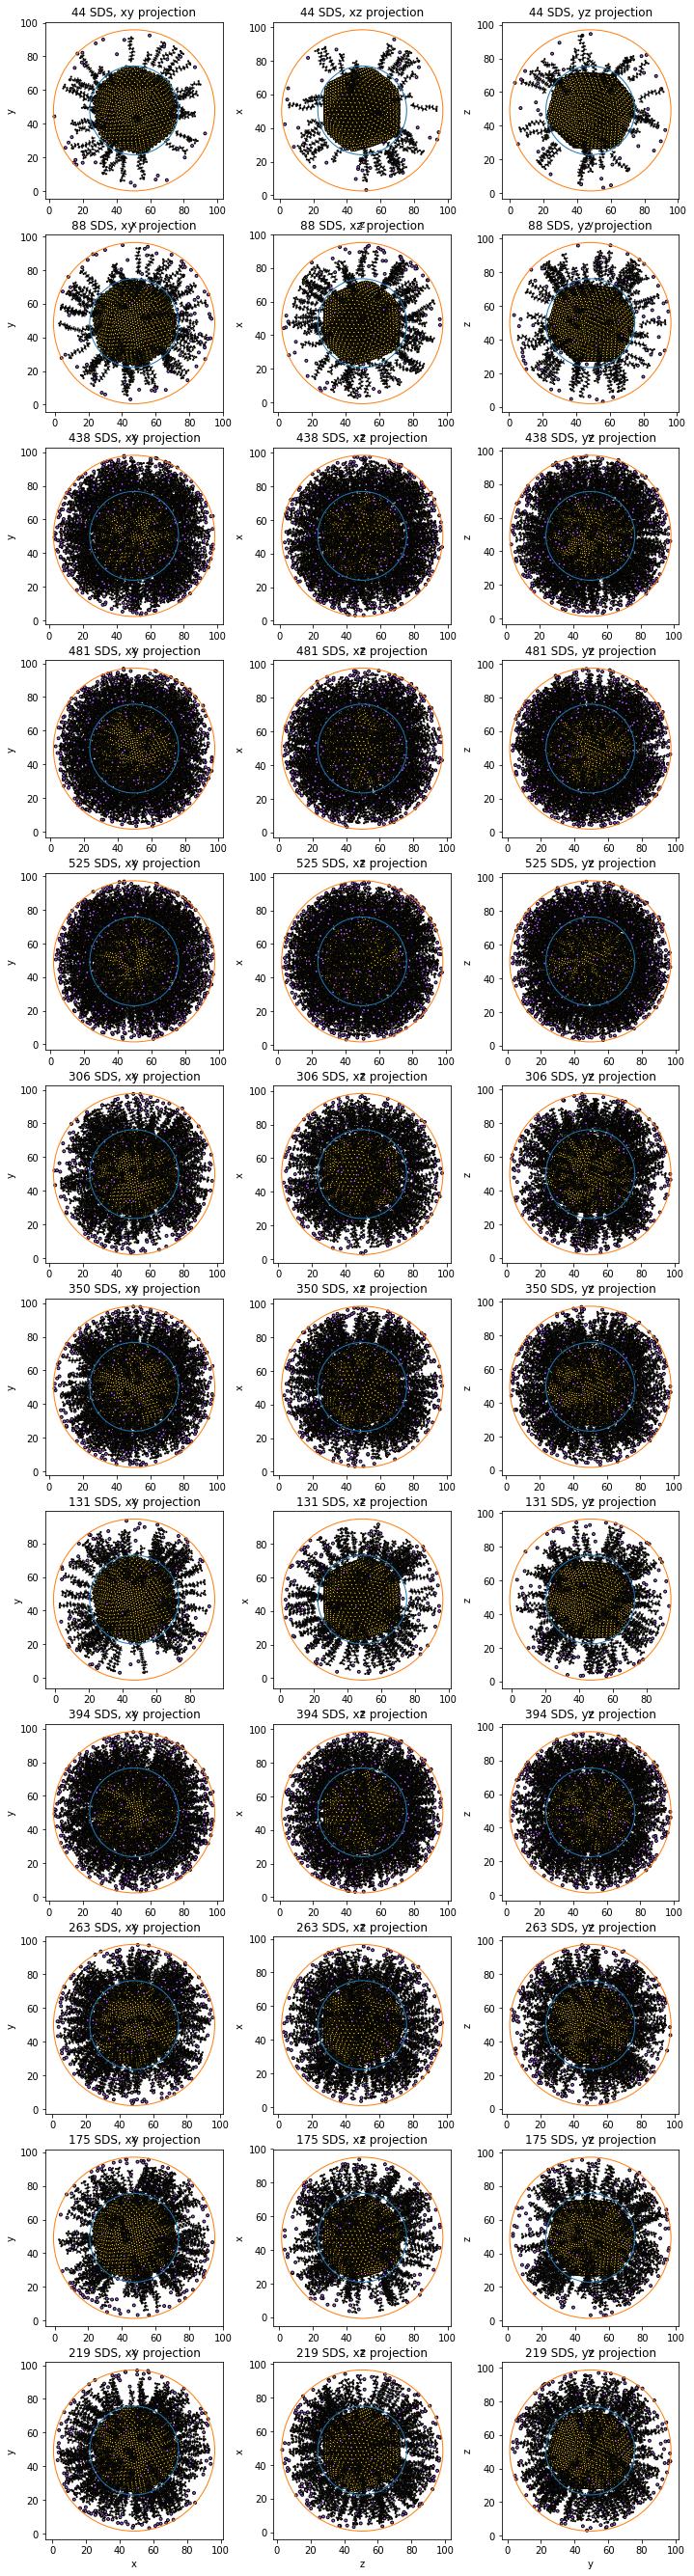

In [80]:
system_selection = surfactant_shell_pmd_list
nx = 3
ny = len(system_selection)
view_labels = ['xy','xz','yz']

molecule_counter = lambda s: np.count_nonzero([r.name == 'SDS' for r in s.residues])

label_generator = lambda i,j: '{:d} SDS, {:s} projection'.format(
    molecule_counter(system_selection[i]),view_labels[j])

figsize = (4*nx,4*ny)
fig, axes = plt.subplots(ny,3,figsize=figsize)

for i,system in enumerate(system_selection):
    system_ase = ase.Atoms(
        numbers=[1 if a.atomic_number == 0 else a.atomic_number for a in system.atoms],
        positions=system.get_coordinates(0))
    
    C_shell, R_sq_shell = miniball.get_bounding_ball(system_ase.get_positions())
    R_shell = np.sqrt(R_sq_shell)
    plot_side_views_with_spheres(
        system_ase,[C,C_shell],[R,R_shell],fig=fig,ax=axes[i,:])
    
    for j, ax in enumerate(axes[i,:]):
        ax.set_title(label_generator(i,j))
        
    del system_ase
    gc.collect()

In [108]:
del fig
del axes

## Prepare a Gromacs-processible system

In [740]:
gromacs.config.logfilename

'gromacs.log'

In [741]:
gromacs.environment.flags

[('capture_output', False), ('capture_output_filename', 'gromacs_captured_output.txt')]

In [742]:
# if true, then stdout and stderr are returned as strings by gromacs wrapper commands
gromacs.environment.flags['capture_output'] = False

In [84]:
print(gromacs.release())

2018.1


In [85]:
prefix

'/mnt/dat/work/testuser/indenter/sandbox/20191110_packmol'

In [539]:
system = '200_SDS_on_50_Ang_AFM_tip_model'
pdb = system + '.pdb'
gro = system + '.gro'
top = system + '.top'
posre = system + '.posre.itp'

### Tidy up packmol's non-standard pdb

In [540]:
# Remove any chain ID from pdb and tidy up
pdb_chain = subprocess.Popen(['pdb_chain',],
        stdin=open(packmol_pdb,'r'),stdout=subprocess.PIPE, stderr=subprocess.PIPE,
        cwd=prefix, encoding='utf-8')
pdb_tidy = subprocess.Popen(['pdb_tidy',],
        stdin=pdb_chain.stdout,stdout=open(pdb,'w'), stderr=subprocess.PIPE,
        cwd=prefix, encoding='utf-8')

### Generate Gromacs .gro and .top

In [541]:
rc,out,err=gromacs.pdb2gmx(
    f=pdb,o=gro,p=top,i=posre,ff='charmm36',water='tip3p',
    stdout=False,stderr=False)

In [542]:
print(out)


Using the Charmm36 force field in directory /opt/apps/gromacs-top/jlh-2018.1/share/gromacs/top/charmm36.ff

Reading 200_SDS_on_50_Ang_AFM_tip_model.pdb...
Read 'Built with Packmol', 12473 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 4273 residues with 12473 atoms

  chain  #res #atoms
  1 ' '  4273  12473  

Reading residue database... (charmm36)
Processing chain 1 (12473 atoms, 4273 residues)

This chain lacks identifiers, which makes it impossible to do strict
classification of the start/end residues. Here we need to guess this residue
should not be part of the chain and instead introduce a break, but that will
be catastrophic if they should in fact be linked. Please check your structure,
and add AUM to residuetypes.dat if this was not correct.


This chain lacks identifiers, which makes it impossible to do strict
classification of the start/end residues. Here we need to guess this residue


### Set simulation box size around system

In [543]:
gro_boxed = system + '_boxed.gro'

In [544]:
rc,out,err=gromacs.editconf(
    f=gro,o=gro_boxed,d=2.0,bt='cubic',
    stdout=False,stderr=False)

In [545]:
print(out)

Read 12473 atoms
Volume: 780.36 nm^3, corresponds to roughly 351100 electrons
No velocities found
    system size :  9.297  9.372  8.956 (nm)
    diameter    :  9.566               (nm)
    center      :  0.049 -0.168 -0.153 (nm)
    box vectors :  9.296  9.372  8.957 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 780.36               (nm^3)
    shift       :  6.734  6.951  6.936 (nm)
new center      :  6.783  6.783  6.783 (nm)
new box vectors : 13.566 13.566 13.566 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :2496.70               (nm^3)



### Batch processing

#### Buld workflow

In [260]:
machine = 'juwels_devel'

In [261]:
parametric_dimension_labels = ['nmolecules']

In [262]:
parametric_dimensions = [ {
    'nmolecules': N } ]

In [263]:
# for testing
parametric_dimensions = [ {
    'nmolecules': [N[0]] } ]

In [264]:
parameter_sets = list( 
    itertools.chain(*[ 
            itertools.product(*list(
                    p.values())) for p in parametric_dimensions ]) )

parameter_dict_sets = [ dict(zip(parametric_dimension_labels,s)) for s in parameter_sets ]

In [265]:
source_project_id = 'juwels-packmol-2020-03-09'
project_id = 'juwels-gromacs-prep-2020-03-11'

In [266]:
wf_name = 'GROMACS preparations {machine:}, {id:}'.format(machine=machine,id=project_id)

fw_name_template = 'nmolecules: {nmolecules:d}'

fw_list = []

fts = [
    CmdTask(
        cmd='echo',
        opt=['"Dummy root"'],
        store_stdout = False,
        store_stderr = False,
        use_shell    = True,
        fizzle_bad_rc= True) ]
  
files_out = []
    
fw_root = Firework(fts,
    name = wf_name,
    spec = {
        '_category': hpc_max_specs[machine]['fw_noqueue_category'],
        '_files_out': files_out, 
        'metadata': {
          'project': project_id,
          'datetime': str(datetime.datetime.now()),
          'step':    'dummy_root'
        }
    }
)

fw_list.append(fw_root)

## Parametric sweep

for d in parameter_dict_sets:        
    
### File retrieval
    
    #files_in = {'input_file': 'input.template' }
    files_in = {}
    files_out = { 'data_file': 'in.pdb' }
    
    # exports = std_exports[machine].copy()
        
    fts_fetch = [ GetFilesByQueryTask(
            query = {
                'metadata->project':    source_project_id,
                'metadata->type':       'initial_config',
                'metadata->nmolecules': d["nmolecules"]
            },
            sort_key = 'metadata.datetime',
            sort_direction = pymongo.DESCENDING,
            limit = 1,
            new_file_names = ['in.pdb'] ) ]
    
    fw_fetch = Firework(fts_fetch,
        name = ', '.join(('fetch', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            '_files_out': files_out, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'fetch',
                 **d
            }
        },
        parents = [ fw_root ] )
    
    fw_list.append(fw_fetch)
    
### PDB chain

    files_in =  {'data_file': 'in.pdb' }
    files_out = {'data_file': 'out.pdb'}
    
    fts_pdb_chain = CmdTask(
        cmd='pdb_chain',
        opt=['< in.pdb > out.pdb'],
        store_stdout = False,
        store_stderr = False,
        use_shell    = True,
        fizzle_bad_rc= True)
  
    fw_pdb_chain = Firework(fts_pdb_chain,
        name = ', '.join(('pdb_chain', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'pdb_chain',
                 **d
            }
        },
        parents = [ fw_fetch ] )
    
    fw_list.append(fw_pdb_chain)
    
### PDB tidy
    files_in =  {'data_file': 'in.pdb' }
    files_out = {'data_file': 'out.pdb'}
    
    fts_pdb_tidy = CmdTask(
        cmd='pdb_tidy',
        opt=['< in.pdb > out.pdb'],
        store_stdout = False,
        store_stderr = False,
        use_shell    = True,
        fizzle_bad_rc= True)
  
    fw_pdb_tidy = Firework(fts_pdb_tidy,
        name = ', '.join(('pdb_tidy', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'pdb_tidy',
                 **d
            }
        },
        parents = [ fw_pdb_chain ] )
    
    fw_list.append(fw_pdb_tidy)
    
### GMX pdb2gro
    
    files_in =  {'data_file': 'in.pdb' }
    files_out = {
        'coordinate_file': 'default.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp'}
    
    fts_gmx_pdb2gro = [ CmdTask(
        cmd='gmx',
        opt=['pdb2gmx',
             '-f', 'in.pdb',
             '-o', 'default.gro',
             '-p', 'default.top',
             '-i', 'default.posre.itp', 
             '-ff', 'charmm36',
             '-water' , 'tip3p'],
        stderr_file  = 'std.err',
        stdout_file  = 'std.out',
        store_stdout = True,
        store_stderr = True,
        use_shell    = True,
        fizzle_bad_rc= True) ]
  
    fw_gmx_pdb2gro = Firework(fts_gmx_pdb2gro,
        name = ', '.join(('gmx_pdb2gro', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'gmx_pdb2gro',
                 **d
            }
        },
        parents = [ fw_pdb_tidy ] )
    
    fw_list.append(fw_gmx_pdb2gro)
    
    
### GMX editconf
    files_in = {
        'coordinate_file': 'in.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp'}
    files_out = {
        'coordinate_file': 'default.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp'}
    
    fts_gmx_editconf = [ CmdTask(
        cmd='gmx',
        opt=['editconf',
             '-f', 'in.gro',
             '-o', 'default.gro',
             '-d', 2.0, # distance between content and box boundary in nm
             '-bt', 'cubic', # box type
          ],
        stderr_file  = 'std.err',
        stdout_file  = 'std.out',
        store_stdout = True,
        store_stderr = True,
        use_shell    = True,
        fizzle_bad_rc= True) ]
  
    fw_gmx_editconf = Firework(fts_gmx_editconf,
        name = ', '.join(('gmx_editconf', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'gmx_editconf',
                 **d
            }
        },
        parents = [ fw_gmx_pdb2gro ] )
    
    fw_list.append(fw_gmx_editconf)
    
### Store

    #files_in = {'data_file': 'packed.pdb' }
    files_in = {
        'coordinate_file': 'default.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp' }
    
    fts_push = [ 
        AddFilesTask( {
            'compress': True ,
            'paths': "default.gro",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'initial_config_gro',
                 **d } 
        } ),
        AddFilesTask( {
            'compress': True ,
            'paths': "default.top",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'initial_config_top',
                 **d } 
        } ),
        AddFilesTask( {
            'compress': True ,
            'paths': "default.posre.itp",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'initial_config_posre_itp',
                 **d } 
        } ) ]
        
               
    
    fw_push = Firework(fts_push,
        name = ', '.join(('push', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'push',
                 **d
            }
        },
        parents = [ fw_gmx_editconf ] )
        
    fw_list.append(fw_push)

wf = Workflow(fw_list,
    name = wf_name,
    metadata = {
        'project': project_id,
        'datetime': str(datetime.datetime.now()),
        'type':    'gmx_prep'
    })

In [267]:
wf.as_dict()

{'fws': [{'spec': {'_category': 'juwels_noqueue',
    '_files_out': [],
    'metadata': {'project': 'juwels-gromacs-prep-2020-03-11',
     'datetime': '2020-03-12 00:15:43.046247',
     'step': 'dummy_root'},
    '_tasks': [{'cmd': 'echo',
      'opt': ['"Dummy root"'],
      'store_stdout': False,
      'store_stderr': False,
      'use_shell': True,
      'fizzle_bad_rc': True,
      '_fw_name': 'CmdTask'}]},
   'fw_id': -150,
   'created_on': '2020-03-11T23:15:43.046289',
   'updated_on': '2020-03-11T23:15:43.046290',
   'name': 'GROMACS preparations juwels_devel, juwels-gromacs-prep-2020-03-11'},
  {'spec': {'_category': 'juwels_noqueue',
    '_files_in': {},
    '_files_out': {'data_file': 'in.pdb'},
    'metadata': {'project': 'juwels-gromacs-prep-2020-03-11',
     'datetime': '2020-03-12 00:15:43.047404',
     'step': 'fetch',
     'nmolecules': '44'},
    '_tasks': [{'query': {'metadata->project': 'juwels-packmol-2020-03-09',
       'metadata->type': 'initial_config',
       'm

In [268]:
lp.add_wf(wf)

2020-03-12 00:15:47,407 INFO Added a workflow. id_map: {-156: 24145, -155: 24146, -154: 24147, -153: 24148, -152: 24149, -151: 24150, -150: 24151}


INFO:launchpad:Added a workflow. id_map: {-156: 24145, -155: 24146, -154: 24147, -153: 24148, -152: 24149, -151: 24150, -150: 24151}


{-156: 24145,
 -155: 24146,
 -154: 24147,
 -153: 24148,
 -152: 24149,
 -151: 24150,
 -150: 24151}

In [269]:
wf.to_file('wf-{:s}.yaml'.format(project_id))

#### Inspect sweep results

In [93]:
query = { 
    "metadata.project": project_id,
}
fp.filepad.count_documents(query)

3

In [94]:
query = { 
    "metadata.project": project_id,
    "metadata.type":    'initial_config_gro',
}
fp.filepad.count_documents(query)

1

In [95]:
parameter_names = ['nmolecules']

In [96]:
gro_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { p: '$metadata.{}'.format(p) for p in parameter_names },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.gro') as tmp:
        tmp.write(content)
        gro_list.append(pmd.load_file(tmp.name))
        
    print('.',end='')
print('')
    

.


In [99]:
gro_list

[<Structure 5765 atoms; 3961 residues; 1804 bonds; PBC (orthogonal); NOT parametrized>]

In [100]:
# with ParmEd and nglview we get automatic bond guessing
pmd_view = nglview.show_parmed(gro_list[0])
pmd_view.clear_representations()
pmd_view.background = 'white'
pmd_view.add_representation('ball+stick')
pmd_view

NGLWidget()

## Energy minimization with restraints

Just to be safe, relax the system a little with positional constraints applied to all ions.

### Compile system

In [546]:
os.getcwd()

'/mnt/dat/work/testuser/indenter/sandbox/20191110_packmol'

In [547]:
em_mdp = gromacs.fileformats.MDP('em.mdp.template')
# no change
em_mdp.write('em.mdp')

In [548]:
gmx_grompp = gromacs.grompp.Popen(
    f='em.mdp',c=gro,r=gro,o='em.tpr',p=top,
    stdout=subprocess.PIPE,stderr=subprocess.PIPE)

out = gmx_grompp.stdout.read()
err = gmx_grompp.stderr.read()

In [549]:
print(err)


libgomp: Invalid value for environment variable OMP_NUM_THREADS
                      :-) GROMACS - gmx grompp, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Gr

In [551]:
print(out)

Analysing residue names:
There are:  3873  Substrate residues
There are:   200 Surfactant residues
There are:   200        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 80x80x80, spacing 0.116 0.117 0.112
This run will generate roughly 51 Mb of data



### Run energy minimization

In [552]:
gmx_mdrun = gromacs.mdrun.Popen(
    deffnm='em',v=True,
    stdout=subprocess.PIPE,stderr=subprocess.PIPE)

In [553]:
for line in gmx_mdrun.stdout: 
    print(line.decode(), end='')

KeyboardInterrupt: 

In [ ]:
out = gmx_mdrun.stdout.read()
err = gmx_mdrun.stderr.read()

In [ ]:
print(err)

In [ ]:
print(out)

### Energy minimization analysis

In [319]:
em_file = 'em.edr'

In [320]:
em_df = panedr.edr_to_df(em_file)

In [554]:
em_df.columns

Index(['Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14', 'Coulomb-14', 'LJ (SR)',
       'Coulomb (SR)', 'Coul. recip.', 'Potential', 'Pressure', 'Vir-XX',
       'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY',
       'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY',
       'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen', 'T-rest'],
      dtype='object')

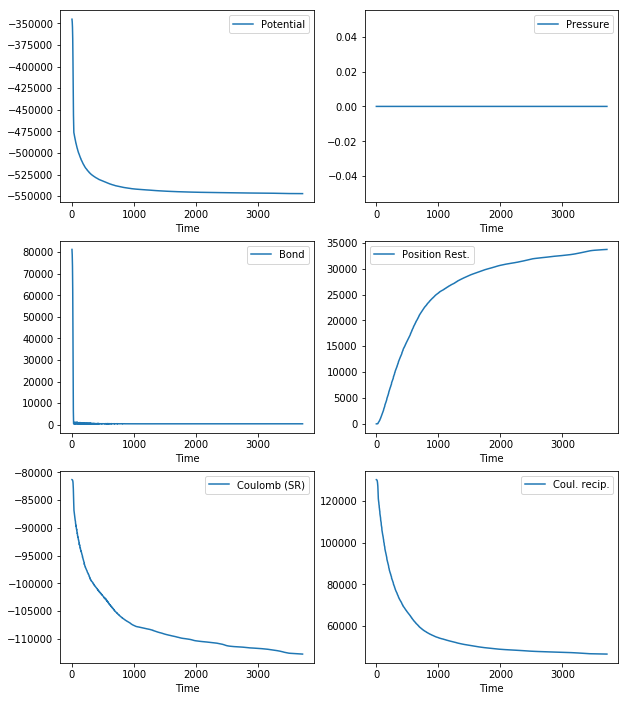

In [322]:
fig, ax = plt.subplots(3,2,figsize=(10,12))
em_df.plot('Time','Potential',ax=ax[0,0])
em_df.plot('Time','Pressure',ax=ax[0,1])
em_df.plot('Time','Bond',ax=ax[1,0])
em_df.plot('Time','Position Rest.',ax=ax[1,1])
#em_df.plot('Time','COM Pull En.',ax=ax[1,1])
em_df.plot('Time','Coulomb (SR)',ax=ax[2,0])
em_df.plot('Time','Coul. recip.',ax=ax[2,1])

In [233]:
mda_trr = mda.Universe(gro,'em.trr')

mda_view = nglview.show_mdanalysis(mda_trr)

mda_view.clear_representations()
mda_view.background = 'white'
mda_view.add_representation('ball+stick')
mda_view

ValueError: seek of closed file

### Batch processing

#### Build workflow: em

In [51]:
machine = 'juwels_devel'

In [52]:
parametric_dimension_labels = ['nmolecules']

In [53]:
parametric_dimensions = [ {
    'nmolecules': N } ]

NameError: name 'N' is not defined

In [273]:
# for testing
parametric_dimensions = [ {
    'nmolecules': [N[0]] } ]

In [274]:
parameter_sets = list( 
    itertools.chain(*[ 
            itertools.product(*list(
                    p.values())) for p in parametric_dimensions ]) )

parameter_dict_sets = [ dict(zip(parametric_dimension_labels,s)) for s in parameter_sets ]

In [275]:
source_project_id = 'juwels-gromacs-prep-2020-03-11'
project_id = 'juwels-gromacs-em-2020-03-12'
infile_prefix = 'gmx_em_infiles'

In [276]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [277]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [278]:
infiles = sorted(glob.glob(os.path.join(infile_prefix,'*')))

files = { os.path.basename(f): f for f in infiles }

# metadata common to all these files 
metadata = {
    'project': project_id,
    'type': 'input'
}

fp_files = []

# insert these input files into data base
for name, file_path in files.items():
    identifier = '/'.join((project_id,name)) # identifier is like a path on a file system
    metadata["name"] = name
    fp_files.append( fp.add_file(file_path,identifier=identifier,metadata = metadata) )

2020-03-12 00:16:34,790 WARNING identifier: juwels-gromacs-em-2020-03-12/em.mdp exists. Skipping insertion


In [291]:
wf_name = 'GROMACS energy minimization {machine:}, {id:}'.format(machine=machine,id=project_id)

fw_name_template = 'nmolecules: {nmolecules:d}'

fw_list = []

files_out = { 'input_file': 'default.mdp' }

fts_root = [ 
    GetFilesByQueryTask(
        query = {
            'metadata->project': project_id,
            'metadata->name':    'em.mdp'
        },
        limit = 1,
        new_file_names = ['default.mdp'] ) ]

fw_root = Firework(fts_root,
    name = wf_name,
    spec = {
        '_category': hpc_max_specs[machine]['fw_noqueue_category'],
        '_files_out': files_out, 
        'metadata': {
          'project': project_id,
          'datetime': str(datetime.datetime.now()),
          'step':    'input_file_query'
        }
    }
)

fw_list.append(fw_root)

## Parametric sweep

for d in parameter_dict_sets:        
    
### File retrieval
    
    #files_in = {'input_file': 'input.template' }
    files_in = {}
    files_out = {
        'coordinate_file': 'default.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp',
    }
            
    fts_fetch = [ 
        GetFilesByQueryTask(
            query = {
                'metadata->project':    source_project_id,
                'metadata->type':       'initial_config_gro',
                'metadata->nmolecules': d["nmolecules"]
            },
            sort_key = 'metadata.datetime',
            sort_direction = pymongo.DESCENDING,
            limit = 1,
            new_file_names = ['default.gro'] ),
        GetFilesByQueryTask(
            query = {
                'metadata->project':    source_project_id,
                'metadata->type':       'initial_config_top',
                'metadata->nmolecules': d["nmolecules"]
            },
            sort_key = 'metadata.datetime',
            sort_direction = pymongo.DESCENDING,
            limit = 1,
            new_file_names = ['default.top'] ), 
        GetFilesByQueryTask(
            query = {
                'metadata->project':    source_project_id,
                'metadata->type':       'initial_config_posre_itp',
                'metadata->nmolecules': d["nmolecules"]
            },
            sort_key = 'metadata.datetime',
            sort_direction = pymongo.DESCENDING,
            limit = 1,
            new_file_names = ['default.posre.itp'] ) ]
    
    fw_fetch = Firework(fts_fetch,
        name = ', '.join(('fetch', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            '_files_out': files_out, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'fetch',
                 **d
            }
        },
        parents = [ fw_root ] )
    
    fw_list.append(fw_fetch)
    
### GMX grompp
    files_in = {
        'input_file':      'default.mdp',
        'coordinate_file': 'default.gro',
        'topology_file':   'default.top',
        'restraint_file':  'default.posre.itp'}
    files_out = {
        'input_file': 'default.tpr',
        'parameter_file': 'mdout.mdp' }
    
    fts_gmx_grompp = [ CmdTask(
        cmd='gmx',
        opt=[' grompp',
             '-f', 'default.mdp',
             '-c', 'default.gro',
             '-r', 'default.gro',
             '-o', 'default.tpr',
             '-p', 'default.top',
          ],
        stderr_file  = 'std.err',
        stdout_file  = 'std.out',
        store_stdout = True,
        store_stderr = True,
        use_shell    = True,
        fizzle_bad_rc= True) ]
  
    fw_gmx_grompp = Firework(fts_gmx_grompp,
        name = ', '.join(('gmx_grompp_em', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'gmx_grompp_em',
                 **d
            }
        },
        parents = [ fw_fetch, fw_root ] )
    
    fw_list.append(fw_gmx_grompp)
    
### GMX mdrun

    files_in = {'input_file':   'em.tpr'}
    files_out = {
        'energy_file':     'em.edr',
        'trajectory_file': 'em.trr',
        'final_config':    'em.gro' }
    
    fts_gmx_mdrun = [ CmdTask(
        cmd='gmx',
        opt=[' mdrun',
             '-deffnm', 'em', '-v' ],
        stderr_file  = 'std.err',
        stdout_file  = 'std.out',
        store_stdout = True,
        store_stderr = True,
        use_shell    = True,
        fizzle_bad_rc= True) ]
    
    fw_gmx_mdrun = Firework(fts_gmx_mdrun,
        name = ', '.join(('gmx_mdrun_em', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_queue_category'],
            '_queueadapter': {
                'queue':           hpc_max_specs[machine]['queue'],
                'walltime' :       hpc_max_specs[machine]['walltime'],
                'ntasks':          96,
            },
            '_files_in':  files_in,
            '_files_out': files_out,
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'gmx_mdrun_em',
                 **d
            }
        },
        parents = [ fw_gmx_grompp ] )
    
    fw_list.append(fw_gmx_mdrun)
    
# Store results
    files_in = {
        'energy_file':     'em.edr',
        'trajectory_file': 'em.trr',
        'final_config':    'em.gro' }
    files_out = {}
    
    fts_push = [ 
        AddFilesTask( {
            'compress': True ,
            'paths': "em.edr",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'em_edr',
                 **d } 
        } ),
        AddFilesTask( {
            'compress': True ,
            'paths': "em.trr",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'em_trr',
                 **d } 
        } ),
        AddFilesTask( {
            'compress': True ,
            'paths': "em.gro",
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'type':    'em_gro',
                 **d } 
        } ) ]
    
    fw_push = Firework(fts_push,
        name = ', '.join(('push', fw_name_template.format(**d))),
        spec = {
            '_category': hpc_max_specs[machine]['fw_noqueue_category'],
            '_files_in': files_in, 
            'metadata': {
                'project': project_id,
                'datetime': str(datetime.datetime.now()),
                'step':    'push',
                 **d
            }
        },
        parents = [ fw_gmx_mdrun ] )
        
    fw_list.append(fw_push)

wf = Workflow(fw_list,
    name = wf_name,
    metadata = {
        'project': project_id,
        'datetime': str(datetime.datetime.now()),
        'type':    'gmx_prep'
    })

In [292]:
wf.to_file('wf-{:s}.yaml'.format(project_id))

In [294]:
lp.add_wf(wf)

2020-03-12 00:25:39,438 INFO Added a workflow. id_map: {-176: 24167, -175: 24168, -174: 24169, -173: 24170, -172: 24171}


INFO:launchpad:Added a workflow. id_map: {-176: 24167, -175: 24168, -174: 24169, -173: 24170, -172: 24171}


{-176: 24167, -175: 24168, -174: 24169, -173: 24170, -172: 24171}

#### Build workflow: prep & em

In [450]:
machine = 'juwels_devel'

In [451]:
parametric_dimension_labels = ['nmolecules']

In [452]:
parametric_dimensions = [ {
    'nmolecules': N } ]

In [453]:
# for testing
parametric_dimensions = [ {
    'nmolecules': [N[0]] } ]

In [454]:
parameter_sets = list( 
    itertools.chain(*[ 
            itertools.product(*list(
                    p.values())) for p in parametric_dimensions ]) )

parameter_dict_sets = [ dict(zip(parametric_dimension_labels,s)) for s in parameter_sets ]

In [411]:
source_project_id = 'juwels-packmol-2020-03-09'
project_id = 'juwels-gromacs-em-2020-03-12'
infile_prefix = 'gmx_em_infiles'

In [412]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [413]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

4

In [414]:
infiles = sorted(glob.glob(os.path.join(infile_prefix,'*')))

files = { os.path.basename(f): f for f in infiles }

# metadata common to all these files 
metadata = {
    'project': project_id,
    'type': 'input'
}

fp_files = []

# insert these input files into data base
for name, file_path in files.items():
    identifier = '/'.join((project_id,name)) # identifier is like a path on a file system
    metadata["name"] = name
    fp_files.append( fp.add_file(file_path,identifier=identifier,metadata = metadata) )

2020-03-12 15:36:54,793 WARNING identifier: juwels-gromacs-em-2020-03-12/em.mdp exists. Skipping insertion


In [415]:
wf_name = 'GROMACS preparations & energy minimization, {machine:}, {id:}'.format(machine=machine,id=project_id)

fw_name_template = 'nmolecules: {nmolecules:d}'

fw_list = []

fts_root_dummy = [
    CmdTask(
        cmd='echo',
        opt=['"Dummy root"'],
        store_stdout = False,
        store_stderr = False,
        use_shell    = True,
        fizzle_bad_rc= True) ]
  
files_out = {}
    
fw_root_dummy = Firework(fts_root_dummy,
    name = wf_name,
    spec = {
        '_category': hpc_max_specs[machine]['fw_noqueue_category'],
        '_files_out': files_out, 
        'metadata': {
          'project': project_id,
          'datetime': str(datetime.datetime.now()),
          'step':    'dummy_root'
        }
    }
)

fw_list.append(fw_root_dummy)

files_out = { 'input_file': 'default.mdp' }

fts_root_pull = [ 
    GetFilesByQueryTask(
        query = {
            'metadata->project': project_id,
            'metadata->name':    'em.mdp'
        },
        limit = 1,
        new_file_names = ['default.mdp'] ) ]

fw_root_pull = Firework(fts_root_pull,
    name = wf_name,
    spec = {
        '_category': hpc_max_specs[machine]['fw_noqueue_category'],
        '_files_out': files_out, 
        'metadata': {
          'project': project_id,
          'datetime': str(datetime.datetime.now()),
          'step':    'input_file_query'
        }
    }
)

fw_list.append(fw_root_pull)

## Parametric sweep

for d in parameter_dict_sets:        
    fw_list_tmp, fw_gmx_prep_pull_leaf = sub_wf_gmx_prep_pull(d, [fw_root_dummy])
    fw_list.extend(fw_list_tmp)
    
    fw_list_tmp, fw_gmx_prep_leaf = sub_wf_gmx_prep(d, [fw_gmx_prep_pull_leaf])
    fw_list.extend(fw_list_tmp)
    
    fw_list_tmp, _ = sub_wf_gmx_prep_push(d, [fw_gmx_prep_leaf])
    fw_list.extend(fw_list_tmp)
    
    fw_list_tmp, fw_gmx_mdrun = sub_wf_gmx_em(d, [fw_root_pull,fw_gmx_prep_leaf])
    fw_list.extend(fw_list_tmp)

    fw_list_tmp, fw_gmx_mdrun_push = sub_wf_gmx_em_psuh(d, [fw_gmx_mdrun])
    fw_list.extend(fw_list_tmp)


wf = Workflow(fw_list,
    name = wf_name,
    metadata = {
        'project': project_id,
        'datetime': str(datetime.datetime.now()),
        'type':    'gmx_prep'
    })

In [440]:
fw_list_tmp, fw_gmx_mdrun_push = sub_wf_gmx_em_push(d, None)
#fw_list.extend(fw_list_tmp)

In [441]:
len(fw_list_tmp)

1

In [442]:
sub_wf = Workflow(fw_list_tmp)

In [449]:
lp.append_wf(sub_wf,[24198])

In [447]:
wf.as_dict()

{'fws': [{'spec': {'_category': 'juwels_noqueue',
    '_files_out': {},
    'metadata': {'project': 'juwels-gromacs-em-2020-03-12',
     'datetime': '2020-03-12 15:37:00.156080',
     'step': 'dummy_root'},
    '_tasks': [{'cmd': 'echo',
      'opt': ['"Dummy root"'],
      'store_stdout': False,
      'store_stderr': False,
      'use_shell': True,
      'fizzle_bad_rc': True,
      '_fw_name': 'CmdTask'}]},
   'fw_id': 24207,
   'created_on': '2020-03-12T14:37:00.156126',
   'updated_on': '2020-03-12T14:37:14.190803',
   'state': 'READY',
   'name': 'GROMACS preparations & energy minimization, juwels_devel, juwels-gromacs-em-2020-03-12'},
  {'spec': {'_category': 'juwels_noqueue',
    '_files_out': {'input_file': 'default.mdp'},
    'metadata': {'project': 'juwels-gromacs-em-2020-03-12',
     'datetime': '2020-03-12 15:37:00.156447',
     'step': 'input_file_query'},
    '_tasks': [{'query': {'metadata->project': 'juwels-gromacs-em-2020-03-12',
       'metadata->name': 'em.mdp'},
   

In [417]:
wf.to_file('wf-{:s}.yaml'.format(project_id))

In [418]:
lp.add_wf(wf)

2020-03-12 15:37:14,218 INFO Added a workflow. id_map: {-217: 24196, -216: 24197, -215: 24198, -214: 24199, -213: 24200, -212: 24201, -211: 24202, -210: 24203, -209: 24204, -208: 24205, -207: 24206, -206: 24207}


INFO:launchpad:Added a workflow. id_map: {-217: 24196, -216: 24197, -215: 24198, -214: 24199, -213: 24200, -212: 24201, -211: 24202, -210: 24203, -209: 24204, -208: 24205, -207: 24206, -206: 24207}


{-217: 24196,
 -216: 24197,
 -215: 24198,
 -214: 24199,
 -213: 24200,
 -212: 24201,
 -211: 24202,
 -210: 24203,
 -209: 24204,
 -208: 24205,
 -207: 24206,
 -206: 24207}

#### Inspect sweep results

In [461]:
query = { 
    "metadata.project": project_id,
    "metadata.type":    'em_edr',
}
fp.filepad.count_documents(query)

1

In [462]:
parameter_names = ['nmolecules']

In [532]:
em_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { p: '$metadata.{}'.format(p) for p in parameter_names },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        em_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [[int(metadata["metadata"]["nmolecules"])],em_df.index],
            names=['nmolecules','step'])
        em_mi_df = em_df.set_index(mi)
        em_list.append(em_mi_df)
    print('.',end='')
print('')
em_df = pd.concat(em_list)

.


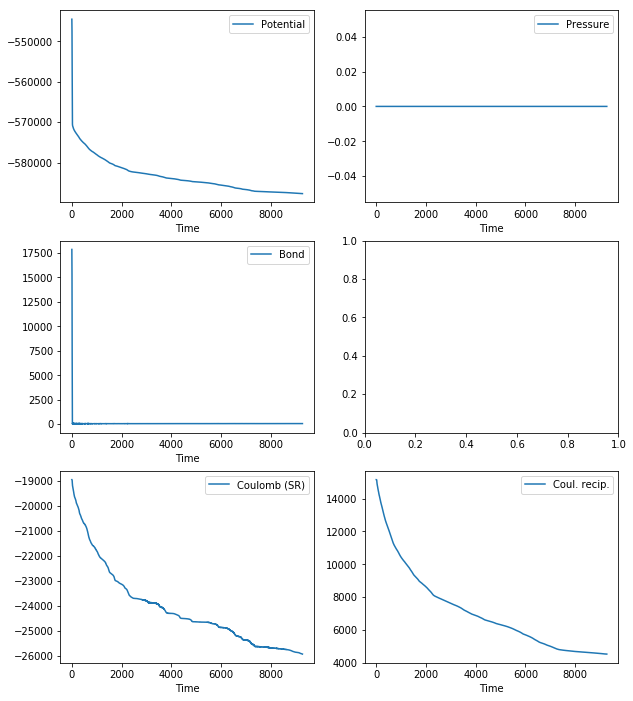

In [537]:
fig, ax = plt.subplots(3,2,figsize=(10,12))
em_df.plot('Time','Potential',ax=ax[0,0])
em_df.plot('Time','Pressure',ax=ax[0,1])
em_df.plot('Time','Bond',ax=ax[1,0])
#em_df.plot('Time','Position Rest.',ax=ax[1,1])
#em_df.plot('Time','COM Pull En.',ax=ax[1,1])
em_df.plot('Time','Coulomb (SR)',ax=ax[2,0])
em_df.plot('Time','Coul. recip.',ax=ax[2,1])

In [559]:
query = { 
    "metadata.project": project_id,
    "metadata.type":    { '$in': ['em_trr','em_gro'] },
}
fp.filepad.count_documents(query)

2

In [731]:
# Building a rather sophisticated aggregation pipeline

parameter_names = ['nmolecules', 'type']

query = { 
    "metadata.project": project_id,
    "metadata.type":    { '$in': ['em_trr','em_gro'] },
}

aggregation_pipeline = []

aggregation_pipeline.append({ 
    "$match": query
})


aggregation_pipeline.append({ 
    "$sort": { 
        "metadata.nmolecules": pymongo.ASCENDING,
        "metadata.datetime": pymongo.DESCENDING,
    }
})

aggregation_pipeline.append({ 
    "$group": { 
        "_id": { p: '$metadata.{}'.format(p) for p in parameter_names },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
})

parameter_names = ['nmolecules']

aggregation_pipeline.append({ 
    "$group": { 
        "_id": { p: '$_id.{}'.format(p) for p in parameter_names },
        "type":     {"$addToSet": "$_id.type"},
        "gfs_id":   {"$addToSet": "$latest"} 
        #"$_id.type": "$latest"
    }
})

aggregation_pipeline.append({
    '$project': {
         '_id': False,
        **{ p: '$_id.{}'.format(p) for p in parameter_names},
        'objects': { 
            '$zip': {
                'inputs': [ '$type', '$gfs_id' ],
                'useLongestLength': True,
                'defaults':  [None,None]
            }
        }
    }
})

aggregation_pipeline.append({ 
    '$project': {
        **{ p: True for p in parameter_names},
        'objects': {'$arrayToObject': '$objects'}
        #'objects': False 
    }
})

aggregation_pipeline.append({ 
    '$addFields': {
        'objects': { **{ p: '${}'.format(p) for p in parameter_names} }
    }
})

aggregation_pipeline.append({ 
    '$replaceRoot': { 'newRoot': '$objects' }
})

# display results with
# for i, c in enumerate(cursor): 
#    print(c)
# yields documents in the form
# {'em_gro': '5e6a4e3d6c26f976ceae5e38', 'em_trr': '5e6a4e3a6c26f976ceae5e14', 'nmolecules': '44'}
# i.e. most recent topology file and trajectory file per concentration

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [732]:
mda_trr_list = []
for i, c in enumerate(cursor): 
    em_gro_content, _ = fp.get_file_by_id(c["em_gro"])
    em_trr_content, _ = fp.get_file_by_id(c["em_trr"])
    # STream approach won't work
    # with io.TextIOWrapper( io.BytesIO(em_gro_content) ) as gro, \
    #    io.BytesIO(em_trr_content) as trr:   
        #mda_trr_list.append( 
        #    mda.Universe( 
        #        gro,trr, topology_format = 'GRO', format='TRR') )
    with tempfile.NamedTemporaryFile(suffix='.gro') as gro, \
        tempfile.NamedTemporaryFile(suffix='.trr') as trr:
        gro.write(em_gro_content)
        trr.write(em_trr_content)
        mda_trr_list.append( mda.Universe(gro.name,trr.name) )
    print('.',end='')
print('')

.


/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [733]:
mda_trr = mda_trr_list[0]

mda_view = nglview.show_mdanalysis(mda_trr)

mda_view.clear_representations()
mda_view.background = 'white'
mda_view.add_representation('ball+stick')
mda_view

/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget(count=74)

### Batch processing: packing, prep & em

In [785]:
machine = 'juwels_devel'

In [786]:
parametric_dimension_labels = ['nmolecules']

In [787]:
N

array([  0,  44,  88, 131, 175, 219, 263, 306, 350, 394, 438, 481, 525])

In [788]:
parametric_dimensions = [ {
    'nmolecules': N } ]

In [789]:
# for testing
parametric_dimensions = [ {
    'nmolecules': [N[-1]] } ]

In [790]:
parameter_sets = list( 
    itertools.chain(*[ 
            itertools.product(*list(
                    p.values())) for p in parametric_dimensions ]) )

parameter_dict_sets = [ dict(zip(parametric_dimension_labels,s)) for s in parameter_sets ]

In [791]:
# source_project_id = 'juwels-packmol-2020-03-09'
project_id = 'juwels-afm-probe-solvation-trial-a-2020-03-13'
# infile_prefix = 'gmx_em_infiles'

In [792]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [793]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

5

#### Provide PACKMOL template 

In [794]:
infile_prefix = os.path.join(prefix,'packmol_infiles')

infiles = sorted(glob.glob(os.path.join(infile_prefix,'*.inp')))

files = { os.path.basename(f): f for f in infiles }

# metadata common to all these files 
metadata = {
    'project': project_id,
    'type': 'template'
}

fp_files = []

# insert these input files into data base
for name, file_path in files.items():
    identifier = '/'.join((project_id,name)) # identifier is like a path on a file system
    metadata["name"] = name
    fp_files.append( fp.add_file(file_path,identifier=identifier,metadata = metadata) )

2020-03-13 12:29:19,686 WARNING identifier: juwels-afm-probe-solvation-trial-a-2020-03-13/surfactants_on_sphere.inp exists. Skipping insertion


In [795]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.type': 'template'
}

# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [796]:
print(identifier)

juwels-afm-probe-solvation-trial-a-2020-03-13/surfactants_on_sphere.inp


In [797]:
# on a lower level, each object has a unique "GridFS id":
pprint(fp_files) # underlying GridFS id and readable identifiers

[('5e6b5e8311940f0e45e46d64',
  'juwels-afm-probe-solvation-trial-a-2020-03-13/surfactants_on_sphere.inp')]


#### Provide data files

In [798]:
data_prefix = os.path.join(prefix,'packmol_datafiles')

In [799]:
datafiles = sorted(glob.glob(os.path.join(data_prefix,'*')))

files = { os.path.basename(f): f for f in datafiles }

# metadata common to all these files 
metadata = {
    'project': project_id,
    'type': 'data'
}

fp_files = []

# insert these input files into data base
for name, file_path in files.items():
    identifier = '/'.join((project_id,name)) # identifier is like a path on a file system
    metadata["name"] = name
    fp_files.append( fp.add_file(file_path,identifier=identifier,metadata = metadata) )


2020-03-13 12:29:35,796 WARNING identifier: juwels-afm-probe-solvation-trial-a-2020-03-13/1_NA.pdb exists. Skipping insertion


2020-03-13 12:29:35,804 WARNING identifier: juwels-afm-probe-solvation-trial-a-2020-03-13/1_SDS.pdb exists. Skipping insertion


2020-03-13 12:29:35,816 WARNING identifier: juwels-afm-probe-solvation-trial-a-2020-03-13/indenter_reres.pdb exists. Skipping insertion


#### Provide energy minimization input files

In [800]:
infile_prefix = 'gmx_em_infiles'

infiles = sorted(glob.glob(os.path.join(infile_prefix,'*')))

files = { os.path.basename(f): f for f in infiles }

# metadata common to all these files 
metadata = {
    'project': project_id,
    'type': 'input'
}

fp_files = []

# insert these input files into data base
for name, file_path in files.items():
    identifier = '/'.join((project_id,name)) # identifier is like a path on a file system
    metadata["name"] = name
    fp_files.append( fp.add_file(file_path,identifier=identifier,metadata = metadata) )

2020-03-13 12:29:42,477 WARNING identifier: juwels-afm-probe-solvation-trial-a-2020-03-13/em.mdp exists. Skipping insertion


#### Build workflow

In [809]:
wf_name = 'pack, preparations & energy minimization, {machine:}, {id:}'.format(machine=machine,id=project_id)

fw_name_template = 'nmolecules: {nmolecules:d}'

fw_list = []

# sub-wf pack root
fts_root_pack = [ 
        GetFilesByQueryTask(
            query = {
                'metadata->project': project_id,
                'metadata->name':    'surfactants_on_sphere.inp'
            },
            limit = 1,
            new_file_names = ['input.template'] ),
        GetFilesByQueryTask(
            query = {
                'metadata->project': project_id,
                'metadata->name':    'indenter_reres.pdb'
            },
            limit = 1,
            new_file_names = ['indenter.pdb'] ),
        GetFilesByQueryTask(
            query = {
                'metadata->project': project_id,
                'metadata->name':    '1_SDS.pdb'
            },
            limit = 1,
            new_file_names = ['1_SDS.pdb'] ),
        GetFilesByQueryTask(
            query = {
                'metadata->project': project_id,
                'metadata->name':    '1_NA.pdb'
            },
            limit = 1,
            new_file_names = ['1_NA.pdb'] )
        ]

files_out = {
    'input_file': 'input.template',
    'indenter_file': 'indenter.pdb',
    'surfatcant_file': '1_SDS.pdb',
    'counterion_file': '1_NA.pdb'}

fw_root_pack = Firework(fts_root_pack,
    name = wf_name,
    spec = {
        '_category': hpc_max_specs[machine]['fw_noqueue_category'],
        '_files_out': files_out, 
        'metadata': {
          'project': project_id,
          'datetime': str(datetime.datetime.now()),
          'subwf':   'pack',
          'step':    'input_file_query'
        }
    }
)

fw_list.append(fw_root_pack)

# sub-wf gmx prep root

fts_root_prep = [
    CmdTask(
        cmd='echo',
        opt=['"Dummy root"'],
        store_stdout = False,
        store_stderr = False,
        use_shell    = True,
        fizzle_bad_rc= True) ]
  
files_out = {}

fw_root_prep = Firework(fts_root_prep,
    name = wf_name,
    spec = {
        '_category': hpc_max_specs[machine]['fw_noqueue_category'],
        '_files_out': files_out, 
        'metadata': {
          'project': project_id,
          'datetime': str(datetime.datetime.now()),
          'subwf':   'prep',
          'step':    'dummy_root'
        }
    }
)

fw_list.append(fw_root_prep)

# sub-wf gmx em root
files_out = { 'input_file': 'default.mdp' }

fts_root_em = [ 
    GetFilesByQueryTask(
        query = {
            'metadata->project': project_id,
            'metadata->name':    'em.mdp'
        },
        limit = 1,
        new_file_names = ['default.mdp'] ) ]

fw_root_em = Firework(fts_root_em,
    name = wf_name,
    spec = {
        '_category': hpc_max_specs[machine]['fw_noqueue_category'],
        '_files_out': files_out, 
        'metadata': {
          'project': project_id,
          'datetime': str(datetime.datetime.now()),
          'subwf':   'em',
          'step':    'input_file_query'
        }
    }
)

fw_list.append(fw_root_em)

## Parametric sweep

for d in parameter_dict_sets:        
    # pack
    fw_list_tmp, fw_pack_leaf = sub_wf_pack(d, [fw_root_pack])
    fw_list.extend(fw_list_tmp)
    
    fw_list_tmp, _ = sub_wf_pack_push(d, [fw_pack_leaf])
    fw_list.extend(fw_list_tmp)
    
    # prep
    fw_list_tmp, fw_prep_leaf = sub_wf_gmx_prep(d, [fw_pack_leaf])
    fw_list.extend(fw_list_tmp)
    
    fw_list_tmp, _ = sub_wf_gmx_prep_push(d, [fw_prep_leaf])
    fw_list.extend(fw_list_tmp)
    
    # em
    fw_list_tmp, fw_gmx_mdrun = sub_wf_gmx_em(d, [fw_root_em,fw_prep_leaf])
    fw_list.extend(fw_list_tmp)

    fw_list_tmp, fw_gmx_mdrun_push = sub_wf_gmx_em_push(d, [fw_gmx_mdrun])
    fw_list.extend(fw_list_tmp)
    
wf = Workflow(fw_list,
    name = wf_name,
    metadata = {
        'project': project_id,
        'datetime': str(datetime.datetime.now()),
        'type':    'pack, prep, em'
    })

INFO:__main__:sphere with 525 surfactant molecules in total.
INFO:root:sphere with 525 molecules at [-0.02151743 -0.17756268  0.46946046], radius 45.90747087934146


In [812]:
wf.to_file('wf-{:s}.json'.format(project_id))

In [813]:
lp.add_wf(wf)

2020-03-13 12:33:51,441 INFO Added a workflow. id_map: {-364: 24209, -363: 24210, -362: 24211, -361: 24212, -360: 24213, -359: 24214, -358: 24215, -357: 24216, -356: 24217, -355: 24218, -354: 24219, -353: 24220, -352: 24221, -351: 24222}


INFO:launchpad:Added a workflow. id_map: {-364: 24209, -363: 24210, -362: 24211, -361: 24212, -360: 24213, -359: 24214, -358: 24215, -357: 24216, -356: 24217, -355: 24218, -354: 24219, -353: 24220, -352: 24221, -351: 24222}


{-364: 24209,
 -363: 24210,
 -362: 24211,
 -361: 24212,
 -360: 24213,
 -359: 24214,
 -358: 24215,
 -357: 24216,
 -356: 24217,
 -355: 24218,
 -354: 24219,
 -353: 24220,
 -352: 24221,
 -351: 24222}

## Pulling

Utilize harmonic pulling to attach surfactants to substrate closely.

### Create index groups for pulling

In [816]:
#pdb = '200_SDS_on_50_Ang_AFM_tip_model.pdb'
gro = 'em.gro'
top = 'sys.top'
ndx = 'standard.ndx'

In [743]:
import parmed as pmd
pmd_top_gro = pmd.gromacs.GromacsTopologyFile(top)
#pmd_top_pdb = pmd.gromacs.GromacsTopologyFile(top)

pmd_gro = pmd.gromacs.GromacsGroFile.parse(gro)
pmd_top_gro.box = pmd_gro.box
pmd_top_gro.positions = pmd_gro.positions

#pmd_pdb = pmd.formats.pdb.PDBFile.parse(pdb)
#pmd_top_pdb.box = pmd_pdb.box
#pmd_top_pdb.positions = pmd_pdb.positions

ValueError: Wrong shape for position array

In [327]:
tail_atom_ndx = np.array([
        i+1 for i,a in enumerate(pmd_top_gro.atoms) if a.name == 'C12' and a.residue.name == 'SDS' ])
# gromacs ndx starts at 1

In [814]:
tail_atom_ndx

NameError: name 'tail_atom_ndx' is not defined

### Generate standard index file for system

In [823]:
gmx_make_ndx = gromacs.make_ndx.Popen(
    f=gro,o=ndx,
    input='q',
    stdout=subprocess.PIPE,stderr=subprocess.PIPE)

In [824]:
out_str, err_str = gmx_make_ndx.communicate()

In [825]:
print(out_str)

Going to read 0 old index file(s)
Analysing residue names:
There are:  3873  Substrate residues
There are:   200 Surfactant residues
There are:   200        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              : 12473 atoms
  1 Substrate           :  3873 atoms
  2 AUM                 :  3873 atoms
  3 SDS                 :  8400 atoms
  4 NA                  :   200 atoms
  5 Surfactant          :  8400 atoms
  6 AUM                 :  3873 atoms
  7 SDS                 :  8400 atoms
  8 NA                  :   200 atoms
  9 Ion                 :   200 atoms
 10 AUM                 :  3873 atoms
 11 SDS                 :  8400 atoms
 12 NA                  :   200 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: lis

In [826]:
print(err_str)


libgomp: Invalid value for environment variable OMP_NUM_THREADS
                     :-) GROMACS - gmx make_ndx, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of G

### Enhance standard index file by pulling groups

In [333]:
pull_groups_ndx_in = gromacs.fileformats.NDX(ndx)

In [334]:
pull_groups_ndx_out = gromacs.fileformats.NDX()

In [335]:
for i, a in enumerate(tail_atom_ndx):
    pull_group_name = 'pull_group_{:04d}'.format(i)
    pull_groups_ndx_out[pull_group_name] = a

In [336]:
pull_groups_ndx_in.update(pull_groups_ndx_out)

In [337]:
pull_groups_ndx_in.write('pull_groups.ndx')

### Create mdp input file with pulling groups and coordinates

In [445]:
# gromacs wrapper parses mdp files
pull_mdp = gromacs.fileformats.MDP('pull.mdp.template')

pull_mdp['nsteps']  = 10000

N_pull_coords = len(pull_groups_ndx_out)

pull_mdp['pull_ncoords']  = N_pull_coords
pull_mdp['pull_ngroups']  = N_pull_coords + 1
pull_mdp['pull_group1_name'] = 'Substrate' # the reference group

for i, n in enumerate(pull_groups_ndx_out):
    pull_mdp["pull_group{:d}_name".format(i+2)]   = n
    pull_mdp["pull_coord{:d}_type".format(i+1)]     = 'umbrella'  # harmonic potential
    pull_mdp["pull_coord{:d}_geometry".format(i+1)] = 'distance'  # simple distance increase
    pull_mdp["pull_coord{:d}_dim".format(i+1)]      = 'Y Y Y'     # pull in all directions
    pull_mdp["pull_coord{:d}_groups".format(i+1)]   = "1 {:d}".format(i+2) # groups 1 (Chain A) and 2 (Chain B) define the reaction coordinate
    pull_mdp["pull_coord{:d}_start".format(i+1)]    = 'yes'       # define initial COM distance > 0
    pull_mdp["pull_coord{:d}_rate".format(i+1)]     = -0.1         # 0.1 nm per ps = 10 nm per ns
    pull_mdp["pull_coord{:d}_k".format(i+1)]        = 1000        # kJ mol^-1 nm^-2

pull_mdp.write('pull.mdp')

### Compile system

In [446]:
gmx_grompp = gromacs.grompp.Popen(
    f='pull.mdp',n='pull_groups.ndx',c=gro,r=gro,o='pull.tpr',p=top,
    stdout=subprocess.PIPE,stderr=subprocess.PIPE)

out = gmx_grompp.stdout.read()

err = gmx_grompp.stderr.read()

In [447]:
print(err)

                      :-) GROMACS - gmx grompp, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [448]:
print(out)

turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 120x120x120, spacing 0.113 0.113 0.113
This run will generate roughly 51 Mb of data



### Run pulling simulation

In [449]:
gmx_mdrun = gromacs.mdrun.Popen(
    deffnm='pull',v=True,
    stdout=subprocess.PIPE,stderr=subprocess.PIPE)

In [450]:
out = gmx_mdrun.stdout.read()
err = gmx_mdrun.stderr.read()

In [451]:
print(err)

                      :-) GROMACS - gmx mdrun, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [456]:
print(out)

### Batch processing

In [72]:
# cast into parameters
surfactant = 'SDS'
tail_atom_name = 'C12'
substrate = 'AUM'
counterion = 'NA'
nsubstrate = 3873

#### Build workflow: pull

In [62]:
machine = 'juwels_devel'

In [63]:
parametric_dimension_labels = ['nmolecules']

In [64]:
parametric_dimensions = [ {
    'nmolecules': N } ]

In [65]:
# for testing
parametric_dimensions = [ {
    'nmolecules': [N[-1]] } ]

In [66]:
parameter_sets = list( 
    itertools.chain(*[ 
            itertools.product(*list(
                    p.values())) for p in parametric_dimensions ]) )

parameter_dict_sets = [ dict(zip(parametric_dimension_labels,s)) for s in parameter_sets ]

In [67]:
source_project_id = 'juwels-gromacs-prep-2020-03-11'
project_id = 'juwels-pull-2020-03-17'
infile_prefix = 'gmx_infiles'

In [68]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [69]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [70]:
infiles = sorted(glob.glob(os.path.join(infile_prefix,'*')))

files = { os.path.basename(f): f for f in infiles }

# metadata common to all these files 
metadata = {
    'project': project_id,
    'type': 'input'
}

fp_files = []

# insert these input files into data base
for name, file_path in files.items():
    identifier = '/'.join((project_id,name)) # identifier is like a path on a file system
    metadata["name"] = name
    fp_files.append( fp.add_file(file_path,identifier=identifier,metadata = metadata) )

2020-03-22 23:56:11,424 WARNING identifier: juwels-pull-2020-03-17/sys.top.template exists. Skipping insertion


In [73]:
wf_name = 'GROMACS surfactant pulling {machine:}, {id:}'.format(machine=machine,id=project_id)

fw_name_template = 'nmolecules: {nmolecules:d}'

fw_list = []

files_out = { 'template_file': 'sys.top.template' }

fts_root_pull = [ 
    GetFilesByQueryTask(
        query = {
            'metadata->project': project_id,
            'metadata->name':    'sys.top.template'
        },
        limit = 1,
        new_file_names = ['sys.top.template'] ) ]

fw_root_pull = Firework(fts_root_pull,
    name = wf_name,
    spec = {
        '_category': hpc_max_specs[machine]['fw_noqueue_category'],
        '_files_out': files_out, 
        'metadata': {
          'project': project_id,
          'datetime': str(datetime.datetime.now()),
          'step':    'input_file_query'
        }
    }
)

fw_list.append(fw_root_pull)

## Parametric sweep

for d in parameter_dict_sets:        
    # pull data files
    fw_list_tmp, fw_pull_pull_leaf = sub_wf_pull_pull(d, [])
    fw_list.extend(fw_list_tmp)
    
    # pull 
    fw_list_tmp, fw_pull_leaf = sub_wf_pull(d, [fw_root_pull,fw_pull_pull_leaf])
    fw_list.extend(fw_list_tmp)

    # push data files
    fw_list_tmp, _ = sub_wf_pull_push(d, [fw_pull_pull_leaf])
    fw_list.extend(fw_list_tmp)
    


wf = Workflow(fw_list,
    name = wf_name,
    metadata = {
        'project': project_id,
        'datetime': str(datetime.datetime.now()),
        'type':    'pull'
    })

RuntimeError: Invalid keyword argument specified for: <class 'imteksimfw.fireworks.user_objects.firetasks.cmd_tasks.CmdTask'>. You specified: use_shell. Allowed values are: ['cmd', 'opt', 'env', 'stdin_file', 'stdin_key', 'stdout_file', 'stderr_file', 'store_stdout', 'store_stderr', 'shell_exe', 'defuse_bad_rc', 'fizzle_bad_rc'].

In [932]:
wf.to_file('wf-{:s}.yaml'.format(project_id))

In [933]:
lp.add_wf(wf)

2020-03-17 23:20:48,638 INFO Added a workflow. id_map: {-429: 24265, -428: 24266, -427: 24267, -426: 24268, -425: 24269, -424: 24270}


INFO:launchpad:Added a workflow. id_map: {-429: 24265, -428: 24266, -427: 24267, -426: 24268, -425: 24269, -424: 24270}


{-429: 24265, -428: 24266, -427: 24267, -426: 24268, -425: 24269, -424: 24270}

## Pulling analysis

### Global observables

In [457]:
edr_file = 'pull.edr'

In [458]:
edr_df = panedr.edr_to_df(edr_file)

In [459]:
edr_df.columns

Index(['Time', 'Restraint Pot.', 'U-B', 'Proper Dih.', 'LJ-14', 'Coulomb-14',
       'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.', 'Position Rest.',
       'COM Pull En.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Temperature', 'Pressure', 'Constr. rmsd', 'Vir-XX', 'Vir-XY', 'Vir-XZ',
       'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY', 'Vir-ZZ', 'Pres-XX',
       'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY', 'Pres-YZ', 'Pres-ZX',
       'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen', 'T-rest'],
      dtype='object')

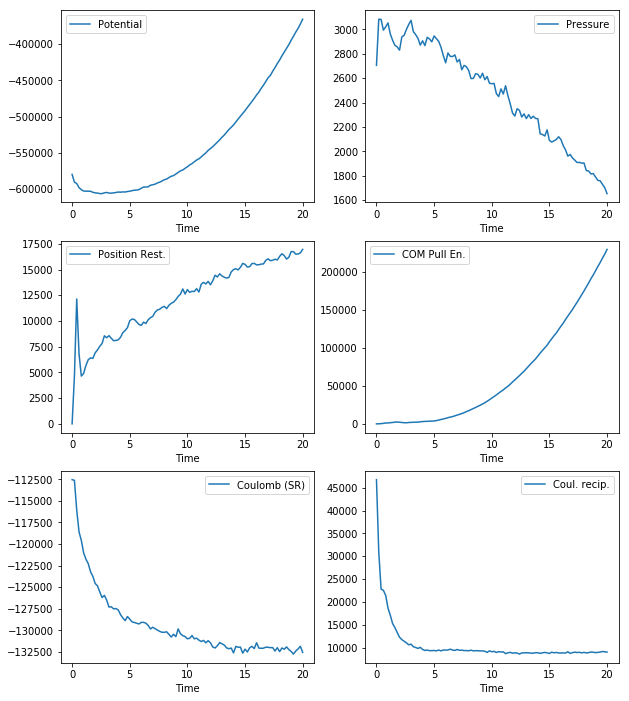

In [460]:
fig, ax = plt.subplots(3,2,figsize=(10,12))
edr_df.plot('Time','Potential',ax=ax[0,0])
edr_df.plot('Time','Pressure',ax=ax[0,1])
#edr_df.plot('Time','Bond',ax=ax[1,0])
edr_df.plot('Time','Position Rest.',ax=ax[1,0])
edr_df.plot('Time','COM Pull En.',ax=ax[1,1])
edr_df.plot('Time','Coulomb (SR)',ax=ax[2,0])
edr_df.plot('Time','Coul. recip.',ax=ax[2,1])

### Pulling forces

In [461]:
# read xvg file
pull_f_xvg = mda.auxiliary.XVG.XVGFileReader('pull_pullf.xvg')
pull_f_t = pull_f_xvg.read_all_times()
# first data column contains time, strip
pull_f = np.array([ f.data[1:] for f in pull_f_xvg ])

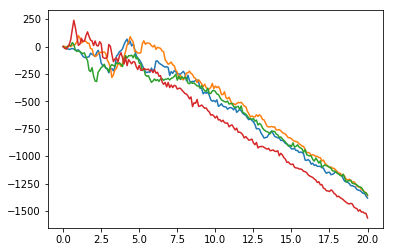

In [462]:
for i in range(0,199,50):
    plt.plot(pull_f_t,pull_f[:,i])

### Pulling groups movement

In [463]:
pull_x_xvg = gromacs.fileformats.XVG('pull_pullx.xvg',)

In [464]:
pull_x_xvg.array

array([[ 0.     ,  0.2    ,  0.4    , ..., 19.6    , 19.8    , 20.     ],
       [ 3.17954,  3.17679,  3.16642, ...,  2.54508,  2.53793,  2.56225],
       [ 3.17949,  3.15949,  3.13949, ...,  1.21949,  1.19949,  1.17949],
       ...,
       [ 4.71707,  4.70175,  4.70073, ...,  4.43672,  4.44362,  4.42686],
       [ 4.59141,  4.67986,  4.6507 , ...,  5.67136,  5.66654,  5.6566 ],
       [ 7.13757,  7.12856,  7.14868, ...,  7.52999,  7.54739,  7.5289 ]])

In [465]:
len(pull_x_xvg.names)

2200

In [466]:
# that many columns perr pull coordinate
N_cols_per_coord = int(len(pull_x_xvg.names) / N_pull_coords)

In [467]:
# with content
legend = pull_x_xvg.names[:11]

In [468]:
legend

['1',
 '1 ref',
 '1 dX',
 '1 dY',
 '1 dZ',
 '1 g 1 X',
 '1 g 1 Y',
 '1 g 1 Z',
 '1 g 2 X',
 '1 g 2 Y',
 '1 g 2 Z']

In [469]:
pull_x_xvg.names[-3:]

['200 g 2 X', '200 g 2 Y', '200 g 2 Z']

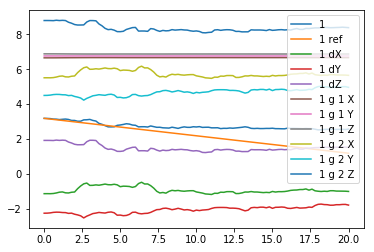

In [470]:
for i in range(11):
    plt.plot(pull_x_xvg.array[0,:],pull_x_xvg.array[i+1,:],label=legend[i])
plt.legend()

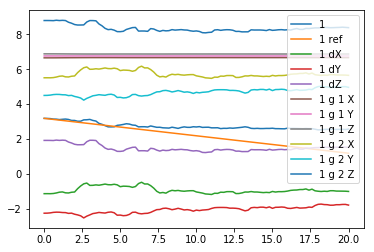

In [471]:
for i in range(11):
    plt.plot(pull_x_xvg.array[0,:],pull_x_xvg.array[i+1,:],label=legend[i])
plt.legend()

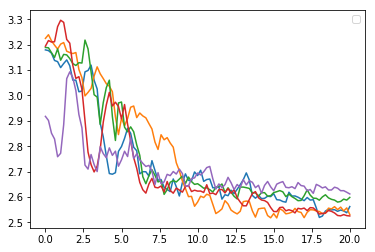

In [472]:
# sqrt(dx^2+dy^2+dz^2), the distance between pulling groups (i.e. one surfactant tail atom and the Au COM)
for i in range(0,150,30):
    plt.plot(pull_x_xvg.array[0,:],
             np.sqrt(pull_x_xvg.array[i*11+3,:]**2+pull_x_xvg.array[i*11+4,:]**2+pull_x_xvg.array[i*11+5,:]**2))
plt.legend()

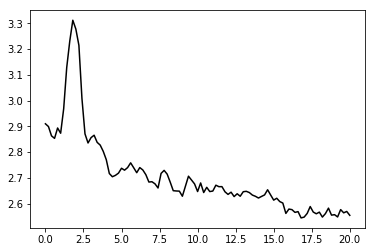

In [473]:
pull_x_xvg.plot(columns=[0,12])

### Visualize trajectory

In [272]:
gro_em = 'pull.gro'

In [273]:
mda_trr = mda.Universe('em.gro','pull.trr')

mda_view = nglview.show_mdanalysis(mda_trr)

mda_view.clear_representations()
mda_view.background = 'white'
mda_view.add_representation('ball+stick')
mda_view

/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no inf

NGLWidget(count=101)

In [536]:
mda_xtc = mda.Universe(gro,'pull.xtc')
mda_view = nglview.show_mdanalysis(mda_xtc)
mda_view.clear_representations()
mda_view.background = 'white'
mda_view.add_representation('ball+stick')
mda_view

/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:196: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=101)

### MSD

In [476]:
substrate = mda_trr.atoms[mda_trr.atoms.names == 'AU']

In [477]:
surfactant_head = mda_trr.atoms[mda_trr.atoms.names == 'S']

In [478]:
rms_substrate = mda_rms.RMSD(substrate,ref_frame=0)

INFO:MDAnalysis.analysis.rmsd:RMS calculation for 3873 atoms.


In [479]:
rms_substrate.run()

INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
INFO:MDAnalysis.analysis.base:Finishing up


In [480]:
rmsd = rms_substrate.rmsd.T   # transpose makes it easier for plotting
time = rmsd[1]

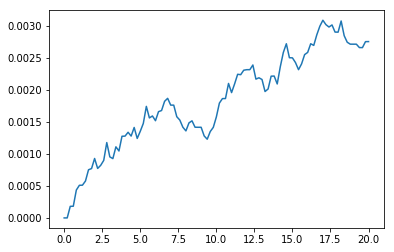

In [481]:
plt.plot(time,rmsd[2])

In [482]:
rms_surfactant_head = mda_rms.RMSD(surfactant_head,ref_frame=0)

INFO:MDAnalysis.analysis.rmsd:RMS calculation for 200 atoms.


In [483]:
rms_surfactant_head.run()

INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
INFO:MDAnalysis.analysis.base:Finishing up


In [484]:
rmsd = rms_surfactant_head.rmsd.T   # transpose makes it easier for plotting
time = rmsd[1]

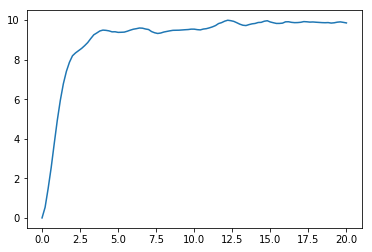

In [485]:
plt.plot(time,rmsd[2])

### Au-S (substrate - head group )RDF

In [486]:
len(mda_trr.trajectory)

101

In [487]:
rdf_substrate_headgroup = mda_rdf.InterRDF(
    substrate,surfactant_head,range=(0.0,80.0),verbose=True)

In [488]:
bins = []
rdf  = []
for i in range(len(mda_trr.trajectory)):
    rdf_substrate_headgroup = mda_rdf.InterRDF(
        substrate,surfactant_head,range=(0.0,80.0),verbose=True)
    rdf_substrate_headgroup.run(start=i,stop=i+1)
    bins.append(rdf_substrate_headgroup.bins.copy())
    rdf.append(rdf_substrate_headgroup.rdf.copy())
bins = np.array(bins)
rdf = np.array(rdf)

INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:

Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalys

INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:MDAnalysis.analysis.base:Finishing up
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
Step     1/1 [100.0%]
INFO:

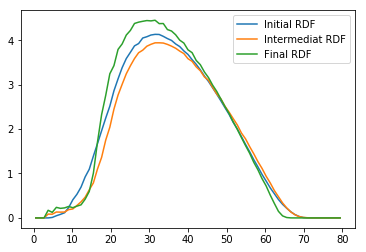

In [489]:
# indicates desired approach towards substrate
plt.plot(bins[0],rdf[0],label="Initial RDF")
plt.plot(bins[3],rdf[4],label="Intermediat RDF")
plt.plot(bins[-1],rdf[-1],label="Final RDF")
plt.legend()

## Solvation

Now, fill the box with water.

In [560]:
gro = 'pull.gro'

In [561]:
# use -scale 0.5 -maxsol N for non-standard conditions
gmx_solvate = gromacs.solvate.Popen(
    cp=gro, cs='spc216.gro',o='solvated.gro',p=top,
    stdout=subprocess.PIPE,stderr=subprocess.PIPE)

out = gmx_solvate.stdout.read()
err = gmx_solvate.stderr.read()

In [562]:
print(out)


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------

Adding line for 77531 solvent molecules to topology file (sys.top)



In [563]:
print(err)

                     :-) GROMACS - gmx solvate, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

## Energy minimization with restraints

Again, relax the system a little with positional constraints applied to all ions.

### Execute trial task via Fireworks on remote resource

In [20]:
lpad = LaunchPad.auto_load()

A trial task sent to FORHLR2:

In [71]:
gmx_test_task = CmdTask(
    cmd = 'gmx',
    opt = '-h',
    stderr_file = 'std.err', 
    stdout_file = 'std.out', 
    use_shell = True)

In [72]:
gmx_test_fw = Firework(
    gmx_test_task, 
    name = 'FORHLR2 GMX test fw',
    spec = { 
        '_category': 'forhlr2_noqueue',
        '_files_out': {
            'stdout': 'std.out',
            'stderr': 'std.err'} 
        } )

In [73]:
fw_ids = lpad.add_wf(gmx_test_fw)

2019-11-29 16:32:52,587 INFO Added a workflow. id_map: {-7: 23404}


INFO:launchpad:Added a workflow. id_map: {-7: 23404}


In [74]:
fw_ids

{-7: 23404}

In [86]:
# lpad.delete_wf(INSERT_ID,delete_launch_dirs=True)

Remove folders ['/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/launcher_2019-11-29-15-23-59-541939']
Remove fws [23402]
Remove launches [18829]
Removing workflow.


### Compile system

In [237]:
top = 'sys.top'

In [238]:
gro = 'solvated.gro'

In [137]:
gmx_grompp = gromacs.grompp.Popen(
    f='em_solvated.mdp',c=gro,r=gro,o='em_solvated.tpr',p=top,
    stdout=subprocess.PIPE,stderr=subprocess.PIPE)

out = gmx_grompp.stdout.read()
err = gmx_grompp.stderr.read()

In [138]:
print(err)

                      :-) GROMACS - gmx grompp, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [139]:
print(out)

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:  3873  Substrate residues
There are:   200 Surfactant residues
There are:   200        Ion residues
There are: 77531      Water residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 120x120x120, spacing 0.113 0.113 0.113
This run will generate roughly 987 Mb of data



### Remote file transfer

Utilize fabric to transfer files files to remote resource conveniently:

In [30]:
c = fabric.Connection('forhlr2') # host defined in ssh config

In [31]:
res = c.run('ws_find fw') # get remote directory of Fireworks workspace

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4)
INFO:paramiko.transport:Authentication (publickey) successful!


/pfs/work6/workspace/scratch/fr_jh1130-fw-0


In [32]:
res.command

'ws_find fw'

In [144]:
now = datetime.now().isoformat()

In [145]:
remote_path = os.path.sep.join((res.stdout.strip(),'file_transfer',now))

In [194]:
remote_path

'/pfs/work6/workspace/scratch/fr_jh1130-fw-0/file_transfer/2019-12-01T19:06:17.131303'

In [147]:
res = c.run(' '.join(['mkdir','-p',remote_path]))

In [148]:
file_name = 'em_solvated.tpr'

In [188]:
local_file = os.path.sep.join((prefix,file_name))

In [189]:
remote_file = os.path.sep.join((remote_path,file_name))

In [198]:
res = c.put(local_file,remote_file)

In [200]:
res.local

'/mnt/dat/work/testuser/indenter/sandbox/20191110_packmol/em_solvated.tpr'

In [193]:
# FileTransferTask does not work anymore

In [191]:
#ft = FileTransferTask(
#    mode   = 'rtransfer',
#    files  = [ {'src':local_file, 'dest':remote_path} ],
#    server = c.host,
#    user   = c.user )

In [192]:
#fw = Firework(
#    ft, 
#    name = 'BWCLOUD remote transef to FORHLR2',
#    spec = { 
#        '_category': 'bwcloud_std',
#        } )

In [174]:
fw_ids = lpad.add_wf(fw)

2019-12-01 19:22:25,477 INFO Added a workflow. id_map: {-9: 23406}


INFO:launchpad:Added a workflow. id_map: {-9: 23406}


### Run energy minimization

In [239]:
ft = FileTransferTask(
    mode   = 'copy',
    files  = [ {'src':remote_file, 'dest':os.path.curdir} ] )

In [240]:
gmx_mdrun_task = CmdTask(
    cmd = 'gmx',
    opt = ['mdrun','-v','-deffnm','em_solvated'],
    stderr_file = 'std.err', 
    stdout_file = 'std.out', 
    use_shell = True)

In [241]:
gmx_log_tracker = Tracker('em_solvated.log')

In [242]:
gmx_mdrun_fw = Firework(
    [ft,gmx_mdrun_task], 
    name = 'FORHLR2 GMX mdrun em_solvated',
    spec = { 
        '_category': 'forhlr2_queue',
        '_queueadapter': {
            'cpus_per_task':    1,
            'ntasks_per_node':  20,
            'ntasks':           40,
            'queue':            'normal',
            'walltime':         '24:00'
        },
        '_files_out': {
            'log': '*.log',
            'trr': '*.trr',
            'edr': '*.edr',
            'gro': '*.gro' },
        '_trackers' : [ gmx_log_tracker ]
        } )

In [243]:
pprint(gmx_mdrun_fw.as_dict())

{'created_on': '2019-12-01T21:24:22.542072',
 'fw_id': -14,
 'name': 'FORHLR2 GMX mdrun em_solvated',
 'spec': {'_category': 'forhlr2_queue',
          '_files_out': {'edr': '*.edr',
                         'gro': '*.gro',
                         'log': '*.log',
                         'trr': '*.trr'},
          '_queueadapter': {'cpus_per_task': 1,
                            'ntasks': 40,
                            'ntasks_per_node': 20,
                            'queue': 'normal',
                            'walltime': '24:00'},
          '_tasks': [{'_fw_name': 'FileTransferTask',
                      'files': [{'dest': '.',
                                 'src': '/pfs/work6/workspace/scratch/fr_jh1130-fw-0/file_transfer/2019-12-01T19:06:17.131303/em_solvated.tpr'}],
                      'mode': 'copy'},
                     {'_fw_name': 'CmdTask',
                      'cmd': 'gmx',
                      'opt': ['mdrun', '-v', '-deffnm', 'em_solvated'],
                 

In [244]:
fw_ids = lpad.add_wf(gmx_mdrun_fw)

2019-12-01 22:24:27,383 INFO Added a workflow. id_map: {-14: 23410}


INFO:launchpad:Added a workflow. id_map: {-14: 23410}


In [315]:
fw_id = list(fw_ids.values())[0]

### File transfer back

instead of relying on the returned fw_id, we can also query the Firework added latest

In [23]:
fw_ids = lpad.get_fw_ids(sort=[('created_on',pymongo.DESCENDING)],limit=1)

In [25]:
fw_id = fw_ids[0]

In [34]:
fw_id

23410

We query the remote directory our FireWork ran in

In [28]:
launch_dir = lpad.get_launchdir(fw_id)

In [35]:
launch_dir

'/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-01-21-24-34-734299'

In [30]:
c = fabric.Connection('forhlr2') # host defined in ssh config

In [36]:
res = c.run('ls -lht {}'.format(launch_dir)) # look at remote directory contents

total 473M
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 9.9K Dec  1 22:31 FORHLR2_GMX_mdrun_em-1644861.out
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 1.2K Dec  1 22:31 FW_offline.json
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay   43 Dec  1 22:31 FW_ping.json
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 784K Dec  1 22:31 std.err
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay    0 Dec  1 22:31 std.out
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 1.6M Dec  1 22:31 em_solvated.edr
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay  11M Dec  1 22:31 em_solvated.gro
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 3.6M Dec  1 22:31 em_solvated.log
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 449M Dec  1 22:31 em_solvated.trr
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 6.9M Dec  1 22:25 em_solvated.tpr
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 4.2K Dec  1 22:25 FW.json
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay    0 Dec  1 22:25 FORHLR2_GMX_mdrun_em-1644861.error
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 

In [39]:
glob_pattern = os.path.join(launch_dir,'em_solvated.*')

In [49]:
res = c.run('ls {}'.format(glob_pattern))

/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-01-21-24-34-734299/em_solvated.edr
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-01-21-24-34-734299/em_solvated.gro
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-01-21-24-34-734299/em_solvated.log
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-01-21-24-34-734299/em_solvated.tpr
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-01-21-24-34-734299/em_solvated.trr


In [53]:
res.stdout

'/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-01-21-24-34-734299/em_solvated.edr\n/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-01-21-24-34-734299/em_solvated.gro\n/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-01-21-24-34-734299/em_solvated.log\n/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-01-21-24-34-734299/em_solvated.tpr\n/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-01-21-24-34-734299/em_solvated.trr\n'

In [57]:
for f in res.stdout.splitlines():
    c.get(f)

### Energy minimization analysis

In [97]:
em_file = 'em_solvated.edr'

In [98]:
em_df = panedr.edr_to_df(em_file)

In [99]:
em_df.columns

Index(['Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14', 'Coulomb-14', 'LJ (SR)',
       'Coulomb (SR)', 'Coul. recip.', 'Position Rest.', 'Potential',
       'Pressure', 'Constr. rmsd', 'Vir-XX', 'Vir-XY', 'Vir-XZ', 'Vir-YX',
       'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY', 'Vir-ZZ', 'Pres-XX', 'Pres-XY',
       'Pres-XZ', 'Pres-YX', 'Pres-YY', 'Pres-YZ', 'Pres-ZX', 'Pres-ZY',
       'Pres-ZZ', '#Surf*SurfTen', 'T-rest'],
      dtype='object')

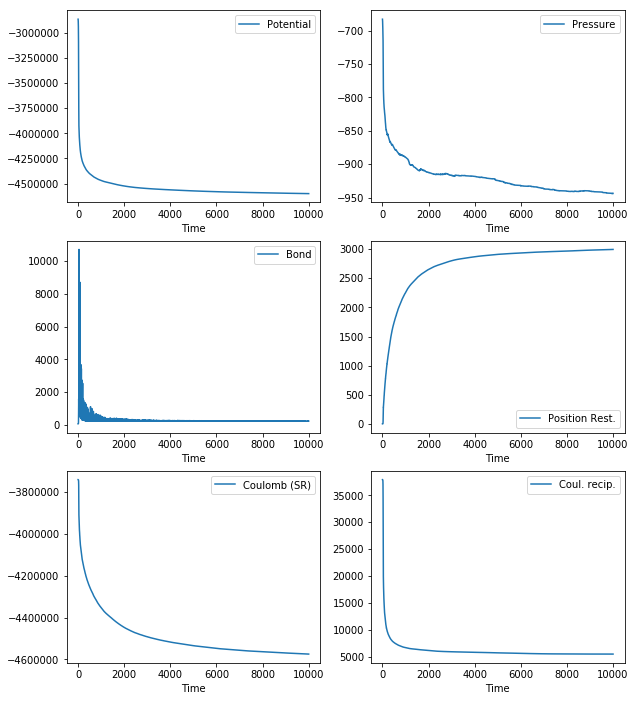

In [100]:
fig, ax = plt.subplots(3,2,figsize=(10,12))
em_df.plot('Time','Potential',ax=ax[0,0])
em_df.plot('Time','Pressure',ax=ax[0,1])
em_df.plot('Time','Bond',ax=ax[1,0])
em_df.plot('Time','Position Rest.',ax=ax[1,1])
#em_df.plot('Time','COM Pull En.',ax=ax[1,1])
em_df.plot('Time','Coulomb (SR)',ax=ax[2,0])
em_df.plot('Time','Coul. recip.',ax=ax[2,1])

In [173]:
try:
    del em_df
except:
    pass

### Visualize trajectory

In [102]:
mda_trr = mda.Universe('solvated.gro','em_solvated.trr')

/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [103]:
# check unique resiude names in system
resnames = np.unique([ r.resname for r in mda_trr.residues ])

In [104]:
resnames

array(['AUM', 'NA', 'SDS', 'SOL'], dtype='<U3')

In [117]:
mda_view = nglview.show_mdanalysis(mda_trr)
mda_view.clear_representations()
mda_view.background = 'white'
mda_view.add_representation(repr_type='ball+stick',selection='SDS')
mda_view.add_representation(repr_type='ball+stick',selection='NA')
mda_view.add_representation(repr_type='spacefill',selection='AUM',color='yellow')
mda_view.center()

In [118]:
mda_view

NGLWidget(count=80)

In [159]:
try:
    del mda_trr
except:
    pass
try:
    del mda_view
except:
    pass

## NVT equilibration

In [134]:
top = 'sys.top'
gro = 'em_solvated.gro'
ndx = 'nvt.ndx'

In [133]:
lpad = LaunchPad.auto_load()

### Generate non-substrate index group

In [141]:
pmd_top_gro = pmd.gromacs.GromacsTopologyFile(top)

pmd_gro = pmd.gromacs.GromacsGroFile.parse(gro)
pmd_top_gro.box = pmd_gro.box
pmd_top_gro.positions = pmd_gro.positions

In [142]:
non_substrate_ndx = np.array([
        i+1 for i,a in enumerate(pmd_top_gro.atoms) if a.residue.name != 'AUM' ])
# gromacs ndx starts at 1

len(pmd_top_gro.atoms)

In [144]:
len(non_substrate_ndx)

241193

In [147]:
len(pmd_top_gro.atoms) - len(non_substrate_ndx) # double-check non-substrate and substrate atom numbers

3873

In [160]:
try:
    del pmd_top_gro
except:
    pass
try:
    del pmd_gro
except:
    pass

### Generate standard index file for system

In [135]:
gmx_make_ndx = gromacs.make_ndx.Popen(
    f=gro,o=ndx,
    input='q',
    stdout=subprocess.PIPE,stderr=subprocess.PIPE)

In [136]:
out_str, err_str = gmx_make_ndx.communicate()

In [137]:
print(out_str)

Going to read 0 old index file(s)
Analysing residue names:
There are:  3873  Substrate residues
There are:   200 Surfactant residues
There are:   200        Ion residues
There are: 77531      Water residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              : 245066 atoms
  1 Substrate           :  3873 atoms
  2 AUM                 :  3873 atoms
  3 SDS                 :  8400 atoms
  4 NA                  :   200 atoms
  5 Surfactant          :  8400 atoms
  6 AUM                 :  3873 atoms
  7 SDS                 :  8400 atoms
  8 NA                  :   200 atoms
  9 Ion                 :   200 atoms
 10 AUM                 :  3873 atoms
 11 SDS                 :  8400 atoms
 12 NA                  :   200 atoms
 13 Water               : 232593 

In [138]:
print(err_str)


libgomp: Invalid value for environment variable OMP_NUM_THREADS
                     :-) GROMACS - gmx make_ndx, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of G

### Enhance standard index file by pulling groups

In [150]:
ndx_in = gromacs.fileformats.NDX(ndx)

In [152]:
ndx_in['non-Substrate'] = non_substrate_ndx

In [155]:
ndx_in.write(ndx)

In [175]:
try:
    del ndx_in
except:
    pass
try:
    del non_substrate_ndx
except:
    pass

### Compile system

In [183]:
gmx_grompp = gromacs.grompp.Popen(
    f='nvt.mdp',n=ndx,c=gro,r=gro,o='nvt.tpr',p=top,
    stdout=subprocess.PIPE,stderr=subprocess.PIPE)

out = gmx_grompp.stdout.read()
err = gmx_grompp.stderr.read()

In [184]:
print(err)


libgomp: Invalid value for environment variable OMP_NUM_THREADS
                      :-) GROMACS - gmx grompp, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Gr

In [185]:
print(out)

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 298.15 K
Calculated rlist for 1x1 atom pair-list as 1.233 nm, buffer size 0.033 nm
Set rlist, assuming 4x4 atom pair-list, to 1.200 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 96x96x96, spacing 0.141 0.141 0.141
This run will generate roughly 987 Mb of data



### Remote file transfer

Utilize fabric to transfer files files to remote resource conveniently:

In [279]:
c = fabric.Connection('forhlr2') # host defined in ssh config

In [280]:
res = c.run('ws_find fw') # get remote directory of Fireworks workspace

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4)
INFO:paramiko.transport:Authentication (publickey) successful!


/pfs/work6/workspace/scratch/fr_jh1130-fw-0


In [281]:
res.command

'ws_find fw'

In [282]:
now = datetime.now().isoformat()

In [283]:
remote_path = os.path.sep.join((res.stdout.strip(),'file_transfer',now))

In [191]:
remote_path

'/pfs/work6/workspace/scratch/fr_jh1130-fw-0/file_transfer/2019-12-05T19:10:15.437758'

In [192]:
res = c.run(' '.join(['mkdir','-p',remote_path]))

In [193]:
file_name = 'nvt.tpr'

In [194]:
local_file = os.path.sep.join((prefix,file_name))

In [195]:
remote_file = os.path.sep.join((remote_path,file_name))

In [196]:
res = c.put(local_file,remote_file)

INFO:paramiko.transport.sftp:[chan 2] Opened sftp connection (server version 3)


In [197]:
res.local

'/mnt/dat/work/testuser/indenter/sandbox/20191110_packmol/nvt.tpr'

### Execute trial task via Fireworks on remote resource queue

In [317]:
ft = FileTransferTask(
    mode   = 'copy',
    files  = [ {'src':remote_file, 'dest':os.path.curdir} ] )

In [318]:
gmx_mdrun_task = CmdTask(
    cmd = 'gmx',
    opt = ['mdrun','-v','-deffnm','nvt'],
    stderr_file = 'std.err', 
    stdout_file = 'std.out', 
    use_shell = True)

In [319]:
gmx_log_tracker = Tracker('nvt.log')

In [320]:
gmx_mdrun_fw = Firework(
    [ft,gmx_mdrun_task], 
    name = 'FORHLR2 GMX mdrun nvt',
    spec = { 
        '_category': 'forhlr2_queue',
        '_queueadapter': {
            'cpus_per_task':    1,
            'ntasks_per_node':  20,
            'ntasks':           20,
            'queue':            'develop',
            'walltime':         '00:03:00'
        },
        '_files_out': {
            'log': '*.log',
            'trr': '*.trr',
            'edr': '*.edr',
            'gro': '*.gro' },
        '_trackers' : [ gmx_log_tracker ]
        } )

In [321]:
pprint(gmx_mdrun_fw.as_dict())

{'created_on': '2019-12-05T23:24:06.054207',
 'fw_id': -15,
 'name': 'FORHLR2 GMX mdrun nvt',
 'spec': {'_category': 'forhlr2_queue',
          '_files_out': {'edr': '*.edr',
                         'gro': '*.gro',
                         'log': '*.log',
                         'trr': '*.trr'},
          '_queueadapter': {'cpus_per_task': 1,
                            'ntasks': 20,
                            'ntasks_per_node': 20,
                            'queue': 'develop',
                            'walltime': '00:03:00'},
          '_tasks': [{'_fw_name': 'FileTransferTask',
                      'files': [{'dest': '.',
                                 'src': '/pfs/work6/workspace/scratch/fr_jh1130-fw-0/file_transfer/2019-12-05T19:10:15.437758/nvt.tpr'}],
                      'mode': 'copy'},
                     {'_fw_name': 'CmdTask',
                      'cmd': 'gmx',
                      'opt': ['mdrun', '-v', '-deffnm', 'nvt'],
                      'stderr_file': 

In [322]:
fw_ids = lpad.add_wf(gmx_mdrun_fw)

2019-12-06 00:24:07,219 INFO Added a workflow. id_map: {-15: 23425}


INFO:launchpad:Added a workflow. id_map: {-15: 23425}


In [332]:
fw_ids = lpad.get_fw_ids(query={'name':'FORHLR2 GMX mdrun nvt','spec._queueadapter.queue':'develop'})

In [333]:
for fw_id in fw_ids:
    try:
        print("Deleting {}...".format(fw_id))
        lpad.delete_wf(fw_id)
    except:
        print("Failed deleting {}...".format(fw_id))
    

Deleting 23412...
Remove fws [23412]
Remove launches [18839]
Removing workflow.
Deleting 23413...
Remove fws [23413]
Remove launches [18840]
Removing workflow.
Deleting 23414...
Remove fws [23414]
Remove launches [18843, 18841, 18842]
Removing workflow.
Deleting 23415...
Remove fws [23415]
Remove launches [18844]
Removing workflow.
Deleting 23416...
Remove fws [23416]
Remove launches [18856, 18845, 18846, 18847, 18848, 18849, 18850, 18851, 18852, 18853, 18854, 18855]
Removing workflow.
Deleting 23417...
Remove fws [23417]
Remove launches [18857]
Removing workflow.
Deleting 23418...
Remove fws [23418]
Remove launches [18861, 18858, 18859, 18860]
Removing workflow.
Deleting 23419...
Remove fws [23419]
Remove launches [18866, 18862, 18863, 18864, 18865]
Removing workflow.
Deleting 23420...
Remove fws [23420]
Remove launches [18867]
Removing workflow.
Deleting 23421...
Remove fws [23421]
Remove launches [18868]
Removing workflow.
Deleting 23422...
Remove fws [23422]
Remove launches [18869]

### Run NVT equilibration

In [198]:
ft = FileTransferTask(
    mode   = 'copy',
    files  = [ {'src':remote_file, 'dest':os.path.curdir} ] )

In [199]:
gmx_mdrun_task = CmdTask(
    cmd = 'gmx',
    opt = ['mdrun','-v','-deffnm','nvt'],
    stderr_file = 'std.err', 
    stdout_file = 'std.out', 
    use_shell = True)

In [200]:
gmx_log_tracker = Tracker('nvt.log')

In [201]:
gmx_mdrun_fw = Firework(
    [ft,gmx_mdrun_task], 
    name = 'FORHLR2 GMX mdrun nvt',
    spec = { 
        '_category': 'forhlr2_queue',
        '_queueadapter': {
            'cpus_per_task':    1,
            'ntasks_per_node':  20,
            'ntasks':           40,
            'queue':            'normal',
            'walltime':         '24:00'
        },
        '_files_out': {
            'log': '*.log',
            'trr': '*.trr',
            'edr': '*.edr',
            'gro': '*.gro' },
        '_trackers' : [ gmx_log_tracker ]
        } )

In [202]:
pprint(gmx_mdrun_fw.as_dict())

{'created_on': '2019-12-05T18:11:31.443409',
 'fw_id': -1,
 'name': 'FORHLR2 GMX mdrun nvt',
 'spec': {'_category': 'forhlr2_queue',
          '_files_out': {'edr': '*.edr',
                         'gro': '*.gro',
                         'log': '*.log',
                         'trr': '*.trr'},
          '_queueadapter': {'cpus_per_task': 1,
                            'ntasks': 40,
                            'ntasks_per_node': 20,
                            'queue': 'normal',
                            'walltime': '24:00'},
          '_tasks': [{'_fw_name': 'FileTransferTask',
                      'files': [{'dest': '.',
                                 'src': '/pfs/work6/workspace/scratch/fr_jh1130-fw-0/file_transfer/2019-12-05T19:10:15.437758/nvt.tpr'}],
                      'mode': 'copy'},
                     {'_fw_name': 'CmdTask',
                      'cmd': 'gmx',
                      'opt': ['mdrun', '-v', '-deffnm', 'nvt'],
                      'stderr_file': 'std.

In [203]:
fw_ids = lpad.add_wf(gmx_mdrun_fw)

2019-12-05 19:11:36,305 INFO Added a workflow. id_map: {-1: 23411}


INFO:launchpad:Added a workflow. id_map: {-1: 23411}


In [204]:
fw_id = list(fw_ids.values())[0]

### File transfer back

instead of relying on the returned fw_id, we can also query the Firework added latest

In [205]:
fw_ids = lpad.get_fw_ids(sort=[('created_on',pymongo.DESCENDING)],limit=1)

In [206]:
fw_id = fw_ids[0]

In [207]:
fw_id

23411

We query the remote directory our FireWork ran in

In [208]:
launch_dir = lpad.get_launchdir(fw_id)

In [209]:
launch_dir

'/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-05-18-11-38-519130'

In [210]:
c = fabric.Connection('forhlr2') # host defined in ssh config

In [211]:
res = c.run('ls -lht {}'.format(launch_dir)) # look at remote directory contents

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4)
INFO:paramiko.transport:Authentication (publickey) successful!


total 969M
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 7.8K Dec  5 19:28 FORHLR2_GMX_mdrun_nv-1648573.out
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 1.2K Dec  5 19:28 FW_offline.json
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay   43 Dec  5 19:28 FW_ping.json
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay  53K Dec  5 19:28 nvt.edr
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay  17M Dec  5 19:28 nvt.gro
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay  82K Dec  5 19:28 nvt.log
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay  32K Dec  5 19:28 std.err
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay    0 Dec  5 19:28 std.out
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 5.7M Dec  5 19:28 nvt.cpt
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 850M Dec  5 19:28 nvt.trr
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay  90M Dec  5 19:28 nvt.xtc
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 4.2K Dec  5 19:14 FW.json
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 7.7M Dec  5 19:14 nvt.tpr
-rw-r--r-- 1 fr_jh1130 fh2-project-multil

In [213]:
glob_pattern = os.path.join(launch_dir,'nvt.*')

In [214]:
res = c.run('ls {}'.format(glob_pattern))

/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-05-18-11-38-519130/nvt.cpt
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-05-18-11-38-519130/nvt.edr
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-05-18-11-38-519130/nvt.gro
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-05-18-11-38-519130/nvt.log
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-05-18-11-38-519130/nvt.tpr
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-05-18-11-38-519130/nvt.trr
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-05-18-11-38-519130/nvt.xtc


In [215]:
for f in res.stdout.splitlines():
    c.get(f)

INFO:paramiko.transport.sftp:[chan 2] Opened sftp connection (server version 3)


### Analysis

In [242]:
edr_file = 'nvt.edr'

In [243]:
edr_df = panedr.edr_to_df(edr_file)

In [244]:
edr_df.columns

Index(['Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14', 'Coulomb-14', 'LJ (SR)',
       'Coulomb (SR)', 'Coul. recip.', 'Potential', 'Kinetic En.',
       'Total Energy', 'Conserved En.', 'Temperature', 'Pressure',
       'Constr. rmsd', 'Vir-XX', 'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY',
       'Vir-YZ', 'Vir-ZX', 'Vir-ZY', 'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ',
       'Pres-YX', 'Pres-YY', 'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ',
       '#Surf*SurfTen', 'T-non-Substrate', 'T-Substrate', 'Lamb-non-Substrate',
       'Lamb-Substrate'],
      dtype='object')

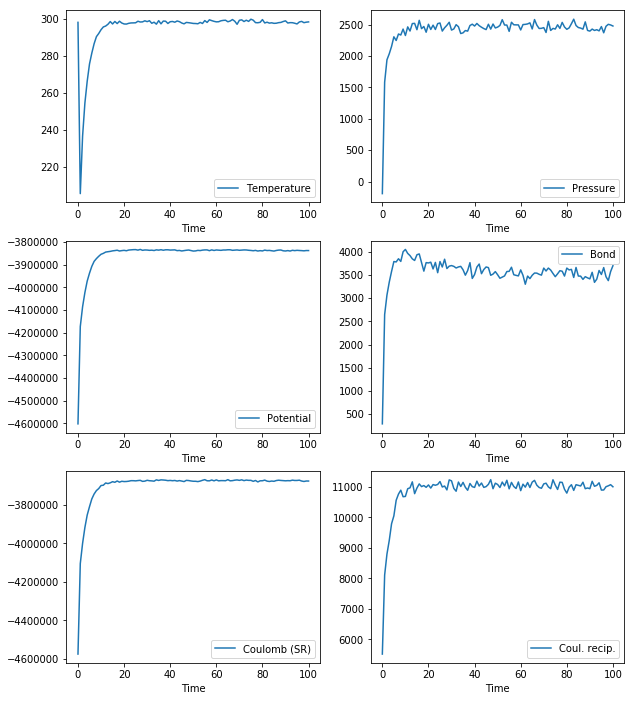

In [248]:
fig, ax = plt.subplots(3,2,figsize=(10,12))
edr_df.plot('Time','Temperature',ax=ax[0,0])
edr_df.plot('Time','Pressure',ax=ax[0,1])
edr_df.plot('Time','Potential',ax=ax[1,0])
edr_df.plot('Time','Bond',ax=ax[1,1])
#edr_df.plot('Time','Position Rest.',ax=ax[1,1])
#edr_df.plot('Time','COM Pull En.',ax=ax[1,1])
edr_df.plot('Time','Coulomb (SR)',ax=ax[2,0])
edr_df.plot('Time','Coul. recip.',ax=ax[2,1])

### Visualize trajectory

In [102]:
mda_trr = mda.Universe('solvated.gro','em_solvated.trr')

/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [103]:
# check unique resiude names in system
resnames = np.unique([ r.resname for r in mda_trr.residues ])

In [104]:
resnames

array(['AUM', 'NA', 'SDS', 'SOL'], dtype='<U3')

In [117]:
mda_view = nglview.show_mdanalysis(mda_trr)
mda_view.clear_representations()
mda_view.background = 'white'
mda_view.add_representation(repr_type='ball+stick',selection='SDS')
mda_view.add_representation(repr_type='ball+stick',selection='NA')
mda_view.add_representation(repr_type='spacefill',selection='AUM',color='yellow')
mda_view.center()

In [118]:
mda_view

NGLWidget(count=80)

In [119]:
try:
    del mda_trr
except:
    pass
try:
    del mda_view
except:
    pass

## NPT equilibration

In [110]:
top = 'sys.top'
gro = 'nvt.gro'
ndx = 'nvt.ndx'

In [111]:
lpad = LaunchPad.auto_load()

### Compile system

In [117]:
gmx_grompp = gromacs.grompp.Popen(
    f='npt.mdp',n=ndx,c=gro,r=gro,o='npt.tpr',p=top,
    stdout=subprocess.PIPE,stderr=subprocess.PIPE)

out = gmx_grompp.stdout.read()
err = gmx_grompp.stderr.read()

In [118]:
print(err)


libgomp: Invalid value for environment variable OMP_NUM_THREADS
                      :-) GROMACS - gmx grompp, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Gr

In [119]:
print(out)

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 298.15 K
Calculated rlist for 1x1 atom pair-list as 1.233 nm, buffer size 0.033 nm
Set rlist, assuming 4x4 atom pair-list, to 1.200 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 96x96x96, spacing 0.141 0.141 0.141
This run will generate roughly 987 Mb of data



### Remote file transfer

Utilize fabric to transfer files files to remote resource conveniently:

In [120]:
c = fabric.Connection('forhlr2') # host defined in ssh config

In [121]:
res = c.run('ws_find fw') # get remote directory of Fireworks workspace

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4)
INFO:paramiko.transport:Authentication (publickey) successful!


/pfs/work6/workspace/scratch/fr_jh1130-fw-0


In [122]:
res.command

'ws_find fw'

In [123]:
now = datetime.now().isoformat()

In [124]:
remote_path = os.path.sep.join((res.stdout.strip(),'file_transfer',now))

In [125]:
remote_path

'/pfs/work6/workspace/scratch/fr_jh1130-fw-0/file_transfer/2019-12-11T19:09:18.744250'

In [126]:
res = c.run(' '.join(['mkdir','-p',remote_path]))

In [127]:
file_name = 'npt.tpr'

In [128]:
local_file = os.path.sep.join((prefix,file_name))

In [129]:
remote_file = os.path.sep.join((remote_path,file_name))

In [130]:
res = c.put(local_file,remote_file)

INFO:paramiko.transport.sftp:[chan 2] Opened sftp connection (server version 3)


### Run NPT equilibration

In [131]:
ft = FileTransferTask(
    mode   = 'copy',
    files  = [ {'src':remote_file, 'dest':os.path.curdir} ] )

In [132]:
gmx_mdrun_task = CmdTask(
    cmd = 'gmx',
    opt = ['mdrun','-v','-deffnm','npt'],
    stderr_file = 'std.err', 
    stdout_file = 'std.out', 
    use_shell = True)

In [133]:
gmx_log_tracker = Tracker('npt.log')

In [134]:
gmx_mdrun_fw = Firework(
    [ft,gmx_mdrun_task], 
    name = 'FORHLR2 GMX mdrun npt',
    spec = { 
        '_category': 'forhlr2_queue',
        '_queueadapter': {
            'cpus_per_task':    1,
            'ntasks_per_node':  20,
            'ntasks':           20,
            'queue':            'normal',
            'walltime':         '24:00:00'
        },
        '_files_out': {
            'log': '*.log',
            'trr': '*.trr',
            'edr': '*.edr',
            'gro': '*.gro' },
        '_trackers' : [ gmx_log_tracker ]
        } )

In [135]:
fw_ids = lpad.add_wf(gmx_mdrun_fw)

2019-12-11 19:09:33,054 INFO Added a workflow. id_map: {-2: 23625}


INFO:launchpad:Added a workflow. id_map: {-2: 23625}


In [136]:
fw_id = list(fw_ids.values())[0]

In [137]:
fw_id

23625

### File transfer back

instead of relying on the returned fw_id, we can also query the Firework added latest

In [47]:
fw_ids = lpad.get_fw_ids(sort=[('created_on',pymongo.DESCENDING)],limit=1)

In [48]:
fw_id = fw_ids[0]

In [49]:
fw_id

23426

We query the remote directory our FireWork ran in

In [50]:
launch_dir = lpad.get_launchdir(fw_id)

In [51]:
launch_dir

'/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-06-00-11-09-904172'

In [52]:
c = fabric.Connection('forhlr2') # host defined in ssh config

In [53]:
res = c.run('ls -lht {}'.format(launch_dir)) # look at remote directory contents

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4)
INFO:paramiko.transport:Authentication (publickey) successful!


total 975M
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 9.9K Dec  8 16:03 FORHLR2_GMX_mdrun_np-1648752.out
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 1.2K Dec  8 16:03 FW_offline.json
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay   43 Dec  8 16:03 FW_ping.json
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay  65K Dec  8 16:03 npt.edr
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay  17M Dec  8 16:03 npt.gro
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay  82K Dec  8 16:03 npt.log
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay  32K Dec  8 16:03 std.err
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay    0 Dec  8 16:03 std.out
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 5.7M Dec  8 16:03 npt.cpt
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 5.7M Dec  8 16:03 npt_prev.cpt
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 850M Dec  8 16:03 npt.trr
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay  90M Dec  8 16:03 npt.xtc
-rw-r--r-- 1 fr_jh1130 fh2-project-multilay 4.2K Dec  8 15:39 FW.json
-rw-r--r-- 1 fr_jh1130 fh2-project-m

In [54]:
glob_pattern = os.path.join(launch_dir,'npt.*')

In [55]:
res = c.run('ls {}'.format(glob_pattern))

/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-06-00-11-09-904172/npt.cpt
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-06-00-11-09-904172/npt.edr
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-06-00-11-09-904172/npt.gro
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-06-00-11-09-904172/npt.log
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-06-00-11-09-904172/npt.tpr
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-06-00-11-09-904172/npt.trr
/pfs/work6/workspace/scratch/fr_jh1130-fw-0/fireworks/launchpad/block_2019-12-01-19-01-57-874819/launcher_2019-12-06-00-11-09-904172/npt.xtc


In [56]:
for f in res.stdout.splitlines():
    c.get(f)

INFO:paramiko.transport.sftp:[chan 2] Opened sftp connection (server version 3)


### Analysis

In [57]:
edr_file = 'npt.edr'

In [58]:
edr_df = panedr.edr_to_df(edr_file)

In [59]:
edr_df.columns

Index(['Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14', 'Coulomb-14', 'LJ (SR)',
       'Coulomb (SR)', 'Coul. recip.', 'Potential', 'Kinetic En.',
       'Total Energy', 'Conserved En.', 'Temperature', 'Pressure',
       'Constr. rmsd', 'Box-X', 'Box-Y', 'Box-Z', 'Volume', 'Density', 'pV',
       'Enthalpy', 'Vir-XX', 'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ',
       'Vir-ZX', 'Vir-ZY', 'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ',
       'Pres-YX', 'Pres-YY', 'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ',
       '#Surf*SurfTen', 'Box-Vel-XX', 'Box-Vel-YY', 'Box-Vel-ZZ',
       'T-non-Substrate', 'T-Substrate', 'Lamb-non-Substrate',
       'Lamb-Substrate'],
      dtype='object')

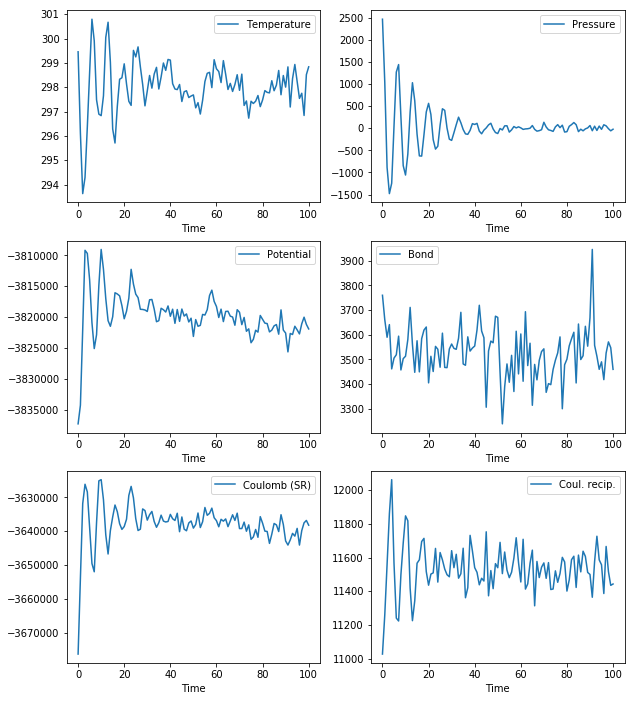

In [60]:
fig, ax = plt.subplots(3,2,figsize=(10,12))
edr_df.plot('Time','Temperature',ax=ax[0,0])
edr_df.plot('Time','Pressure',ax=ax[0,1])
edr_df.plot('Time','Potential',ax=ax[1,0])
edr_df.plot('Time','Bond',ax=ax[1,1])
#edr_df.plot('Time','Position Rest.',ax=ax[1,1])
#edr_df.plot('Time','COM Pull En.',ax=ax[1,1])
edr_df.plot('Time','Coulomb (SR)',ax=ax[2,0])
edr_df.plot('Time','Coul. recip.',ax=ax[2,1])

### Visualize trajectory

In [61]:
mda_trr = mda.Universe('nvt.gro','npt.trr')

/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [62]:
# check unique resiude names in system
resnames = np.unique([ r.resname for r in mda_trr.residues ])

In [63]:
resnames

array(['AUM', 'NA', 'SDS', 'SOL'], dtype='<U3')

In [64]:
mda_view = nglview.show_mdanalysis(mda_trr)
mda_view.clear_representations()
mda_view.background = 'white'
mda_view.add_representation(repr_type='ball+stick',selection='SDS')
mda_view.add_representation(repr_type='ball+stick',selection='NA')
mda_view.add_representation(repr_type='spacefill',selection='AUM',color='yellow')
mda_view.center()

/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/opt/apps/mdtools/jlh-11Jul19/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


In [65]:
mda_view

NGLWidget(count=101)

In [67]:
substrate = mda_trr.select_atoms('resname AUM')

In [103]:
substrate.masses= ase.data.atomic_masses[ase.data.atomic_numbers['Au']]

In [105]:
substrtate_com_traj = np.array([substrate.center_of_mass() for ts in mda_trr.trajectory ])

In [106]:
substrtate_rgyr_traj = np.array([substrate.radius_of_gyration() for ts in mda_trr.trajectory ])

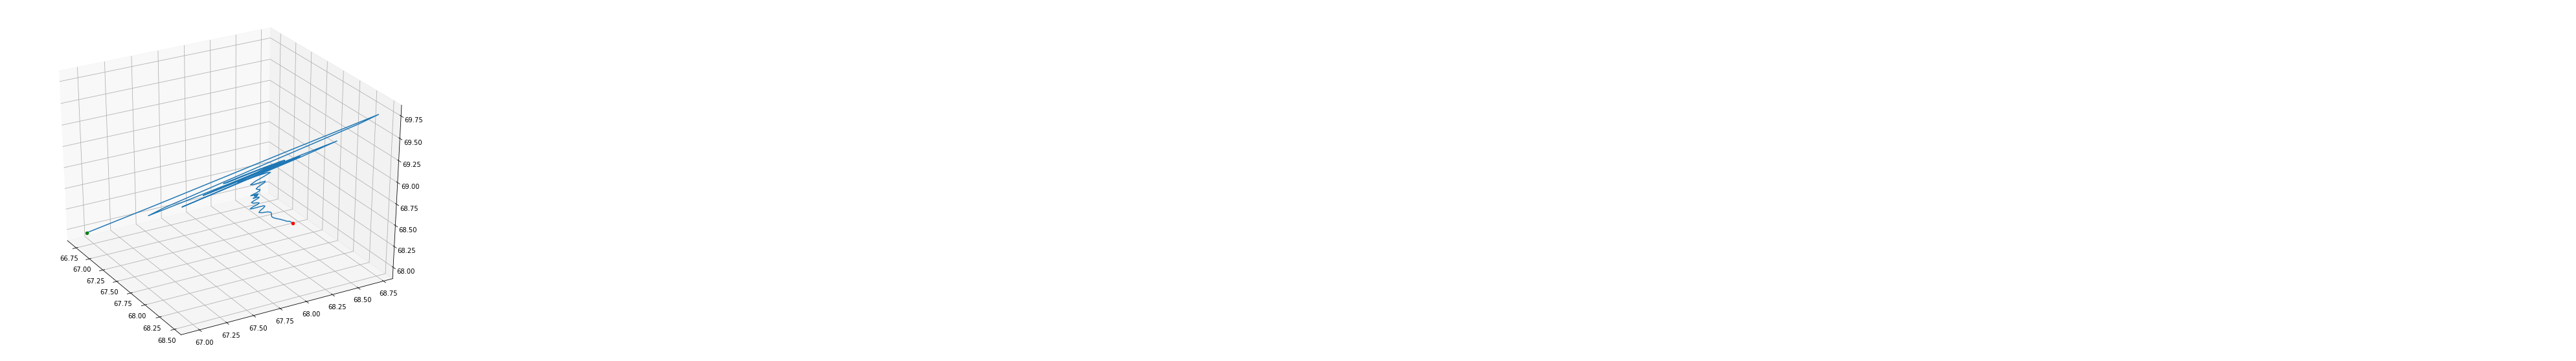

In [107]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d',azim=-30)
ax.plot(*substrtate_com_traj.T)
ax.scatter(*substrtate_com_traj[0,:],color='green')
ax.scatter(*substrtate_com_traj[-1,:],color='red')

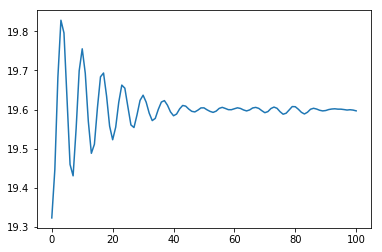

In [109]:
plt.plot(substrtate_rgyr_traj)

In [119]:
try:
    del mda_trr
except:
    pass
try:
    del mda_view
except:
    pass